In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from scipy import signal
from matplotlib import cm


import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [7]:

# Load large image
def load_image(data_directory, image_path):
    # return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    

    mseed_file = f'{data_directory}{image_path}.mseed'
    # mseed_file = "./data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-03-14HR00_evid00018.mseed"
    st = read(mseed_file)

    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    # Start time of trace (another way to get the relative arrival time using datetime)
    starttime = tr.stats.starttime.datetime
    # arrival = (arrival_time - starttime).total_seconds()

    f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)
    # print(len(t))
    freq_mask = (f >= 0.25) & (f <= 1.2)
    f = f[freq_mask]
    sxx = sxx[freq_mask, :]
    # end_time = arrival + 6000
    # time_mask = (t >= arrival) & (t <= end_time)
    # t = t[time_mask]
    # sxx = sxx[:, time_mask]

    return sxx, tr_times, t



# Sliding window function
def sliding_window(image, window_size, step_size):
    for x in range(0, image.shape[1] - window_size[1] + 1, step_size):
        # print(image.shape[0])
        yield x, image[:, x:x + window_size[1]]

def create_dataset(images, coordinates, window_size, step_size):
    samples, labels, positions = [], [], []
    positives = 0
    positive_samples = []  # Store positive sub-images
    for image, y_coord in zip(images, coordinates):
        for x, sub_image in sliding_window(image, window_size, step_size):
            if y_coord >= x and y_coord <= (x + window_size[1] * 0.4):
                label = 1  # Positive sample
                positives += 1
                positive_samples.append(sub_image)  # Add positive sub-image to the list
            else:
                label = 0  # Negative sample

            sub_image_resized = cv2.resize(sub_image, (window_size[1], window_size[0]))
            samples.append(sub_image_resized)
            labels.append(label)
            positions.append(x)  # Store the position of the sliding window

    print(f"Number of positive samples: {positives}")
    return np.array(samples), np.array(labels), positions, positive_samples

def plot_positive_samples(positive_samples):
    # Plot positive sub-images
    num_samples = len(positive_samples)
    plt.figure(figsize=(15, 5))

    # Display positive samples
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(positive_samples[i], cmap='gray')
        plt.axis('off')  # Turn off axis
        plt.title(f'Positive Sample {i + 1}')

    plt.tight_layout()
    plt.show()

# Define a simple CNN model
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),  # Flatten input shape to 1D
        tf.keras.layers.Dense(200, activation='relu'),     # First dense layer
        tf.keras.layers.Dropout(0.5),                      # Dropout layer with 50% dropout rate
        tf.keras.layers.Dense(100, activation='relu'),     # Second dense layer
        tf.keras.layers.Dropout(0.5),                      # Dropout layer with 50% dropout rate
        tf.keras.layers.Dense(1, activation='sigmoid')     # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the CNN
def train_model(x_train, y_train, x_val, y_val, input_shape):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    model = build_model(input_shape)
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, class_weight=class_weight_dict)
    return model




Number of positive samples: 389


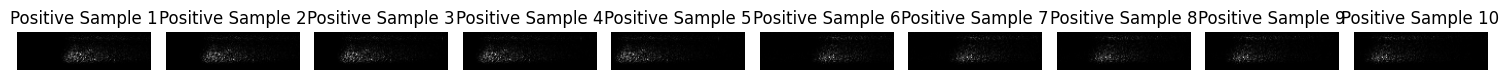

In [8]:
# Load data

cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

data_directory = './data/lunar/training/data/S12_GradeA/'

image_paths = cat["filename"]  # List of image paths
images = [load_image(data_directory, path)[0] for path in image_paths]
timestamps = [load_image(data_directory, path)[1] for path in image_paths]
t = [load_image(data_directory, path)[2] for path in image_paths]
y_coordinates = [np.argmax(image_timestamps > timestamp) for image_timestamps, timestamp in zip(t, cat["time_rel(sec)"])]  # Corresponding y-coordinates where the target starts for each image

window_size = (37, 130)  # (height, width)
step_size = 10

# Create dataset
samples, labels, postitions, positivvvs = create_dataset(images, y_coordinates, window_size, step_size)

global_max = np.max(samples)

samples = samples / global_max

plot_positive_samples(positivvvs[:10])



In [9]:
#training
# Split dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(samples, labels, test_size=0.2, random_state=42)

# Train model
input_shape = (window_size[0], window_size[1], 1)
# model = train_model(x_train, y_train, x_val, y_val, input_shape)
model = train_model(samples, labels, samples, labels, input_shape)

predictions = model.predict(samples)
print(predictions)


# Save model
model.save('cnn_detector.h5')

print("Training complete and model saved.")

c:\Users\student\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9416 - loss: 0.6292 - val_accuracy: 0.9805 - val_loss: 0.1893
Epoch 2/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9406 - loss: 0.3574 - val_accuracy: 0.9775 - val_loss: 0.1566
Epoch 3/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9509 - loss: 0.2569 - val_accuracy: 0.9766 - val_loss: 0.1330
Epoch 4/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9628 - loss: 0.2041 - val_accuracy: 0.9686 - val_loss: 0.3012
Epoch 5/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9653 - loss: 0.1532 - val_accuracy: 0.9729 - val_loss: 0.1893
Epoch 6/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9694 - loss: 0.1528 - val_accuracy: 0.9779 - val_loss: 0.1251
Epoch 7/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9657 - loss: 0.1510 - val_accuracy: 0.9814 - val_loss: 0.0966
Epoch 8/20
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9652 - loss: 0.1521 - 

[[0.02275539]
 [0.02235542]
 [0.02172331]
 ...
 [0.02340556]
 [0.02400373]
 [0.02283875]]
Training complete and model saved.


Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
270


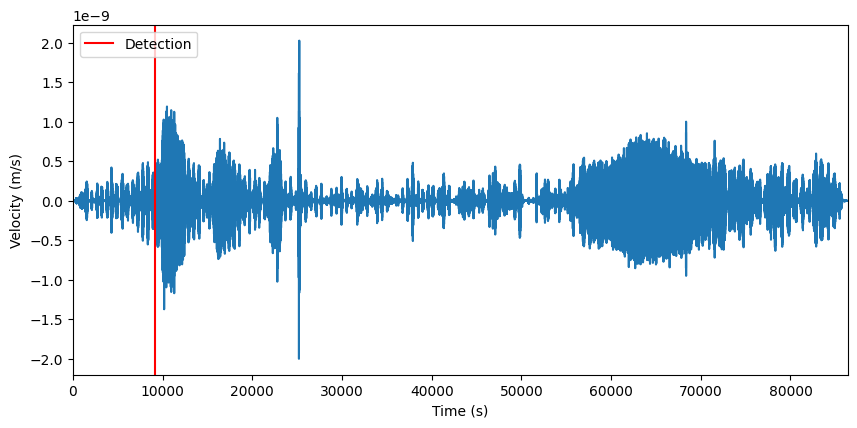

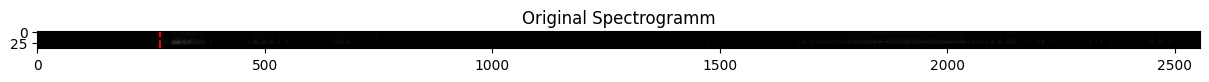

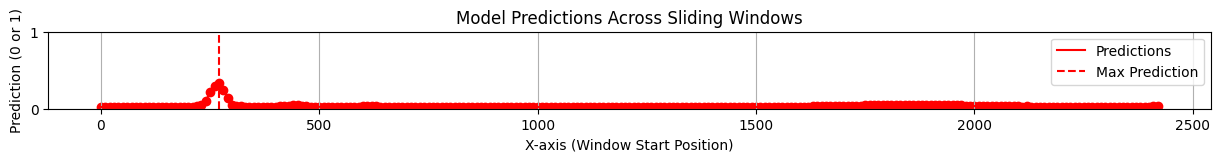

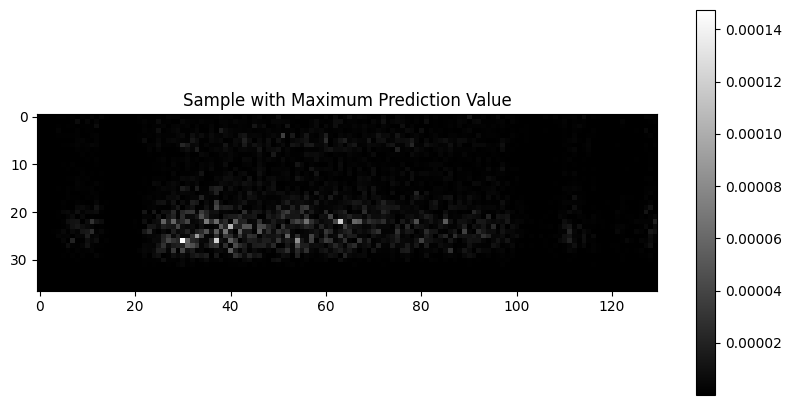

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
40


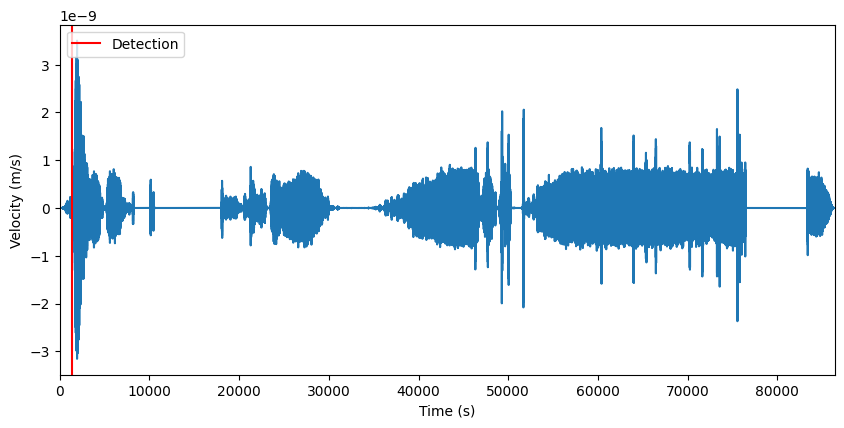

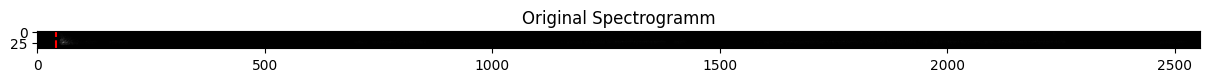

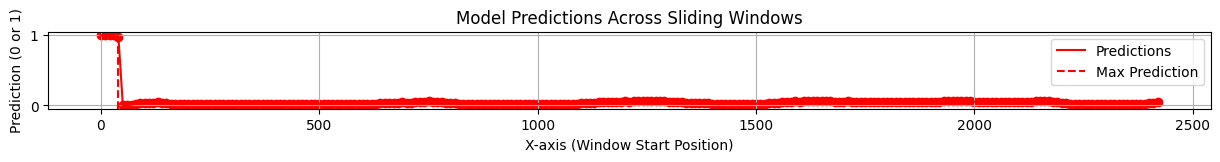

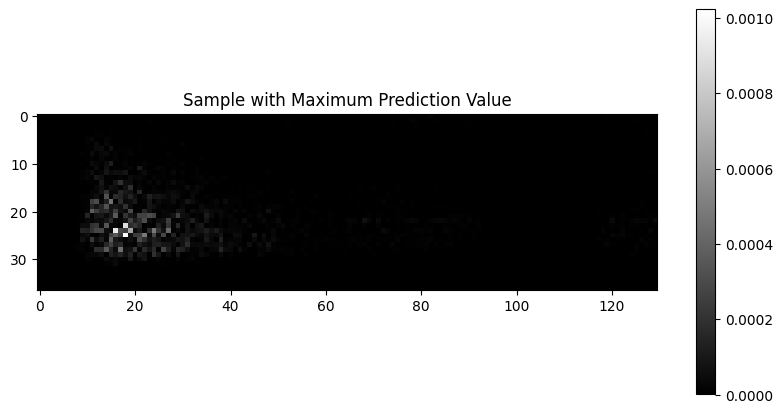

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
340


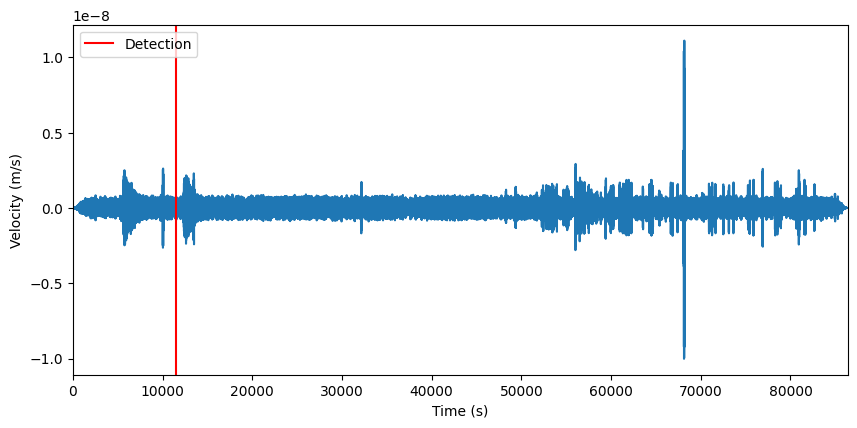

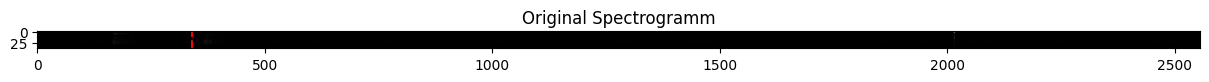

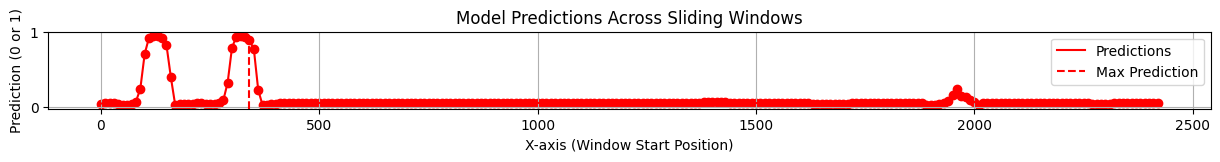

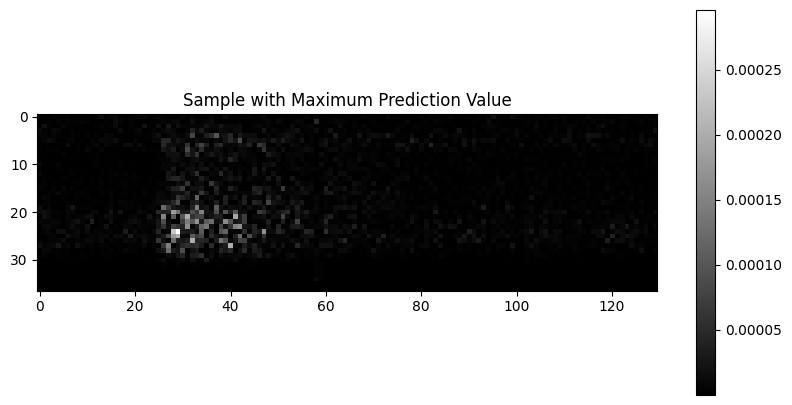

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
200


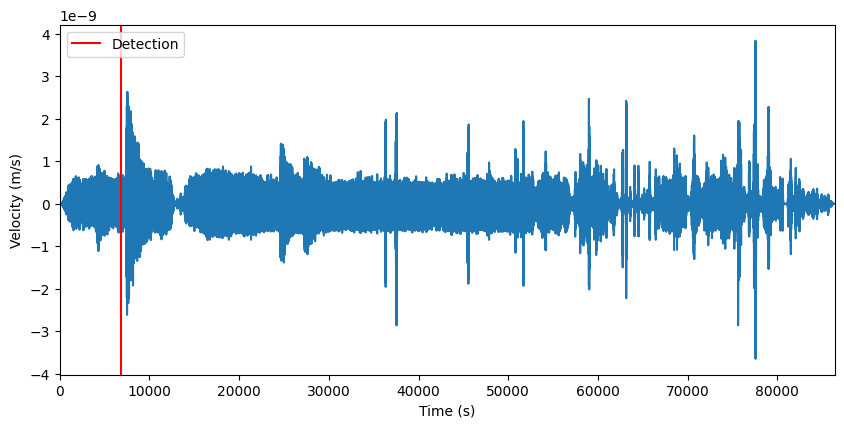

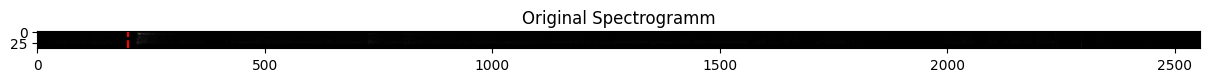

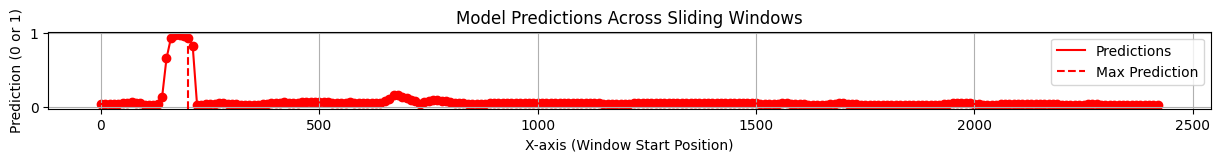

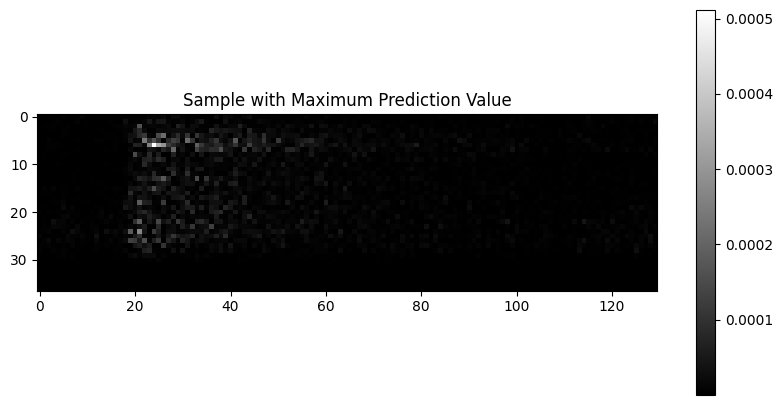

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1300


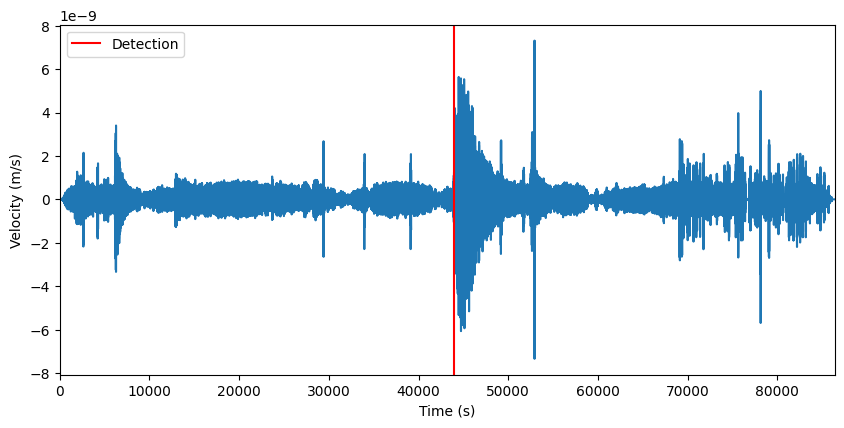

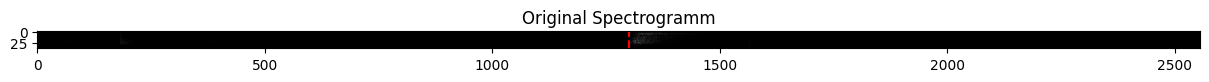

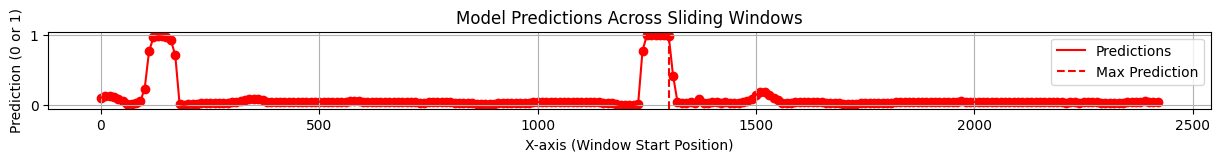

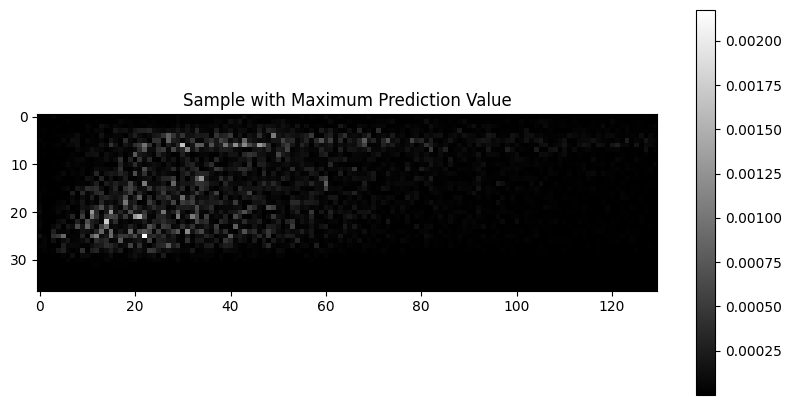

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1270


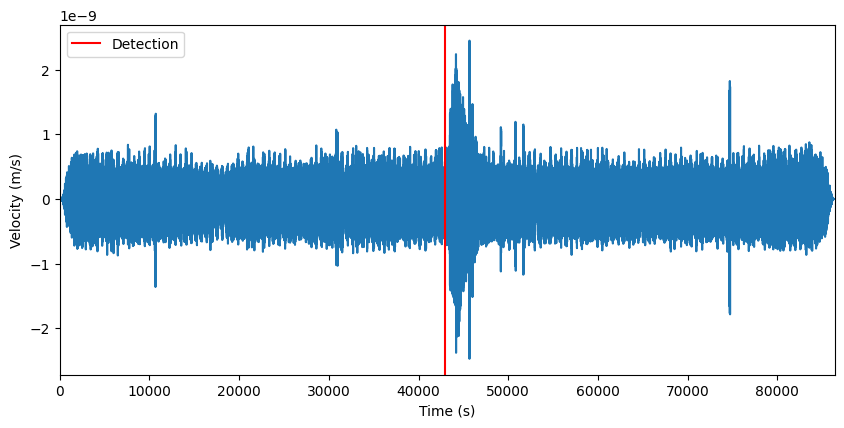

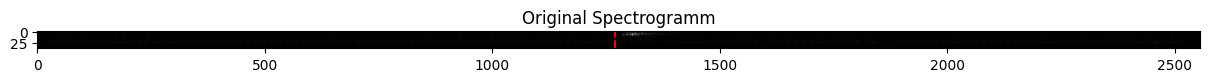

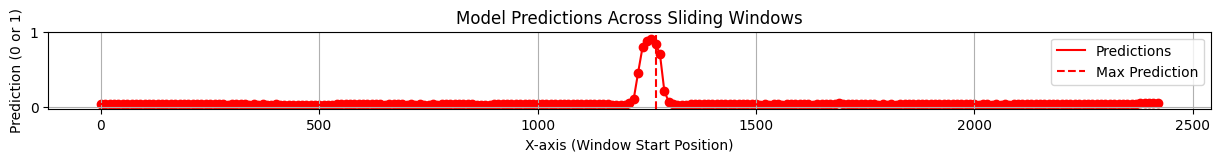

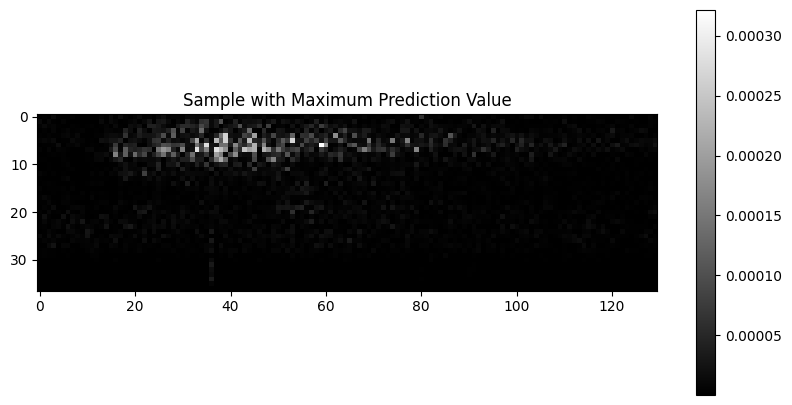

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1880


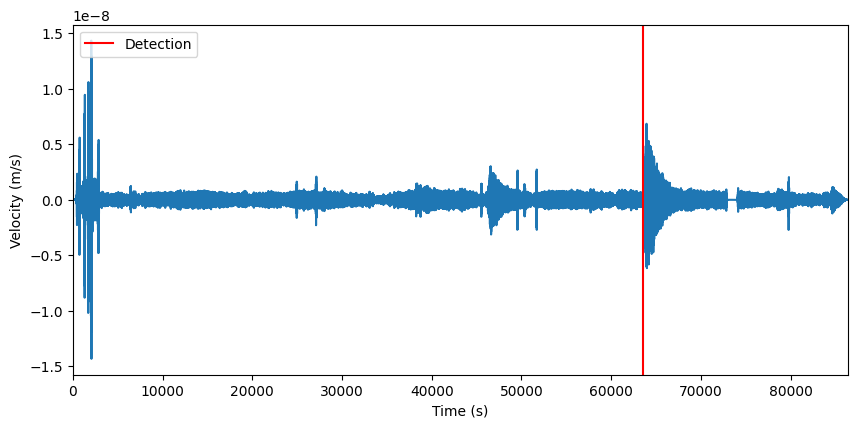

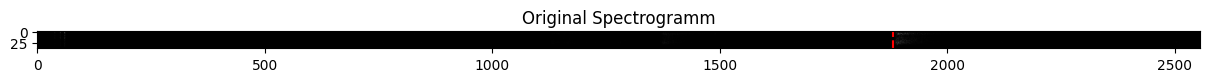

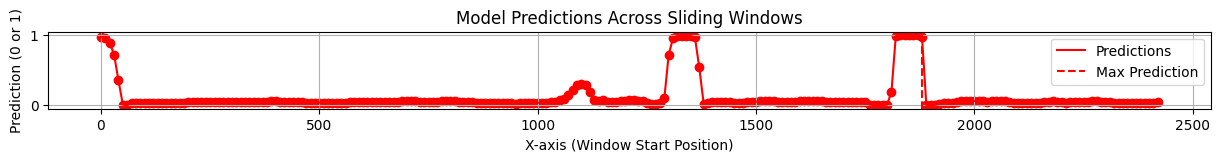

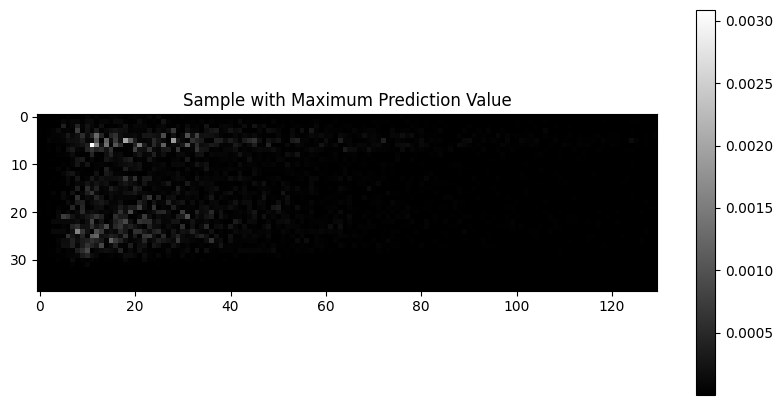

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1140


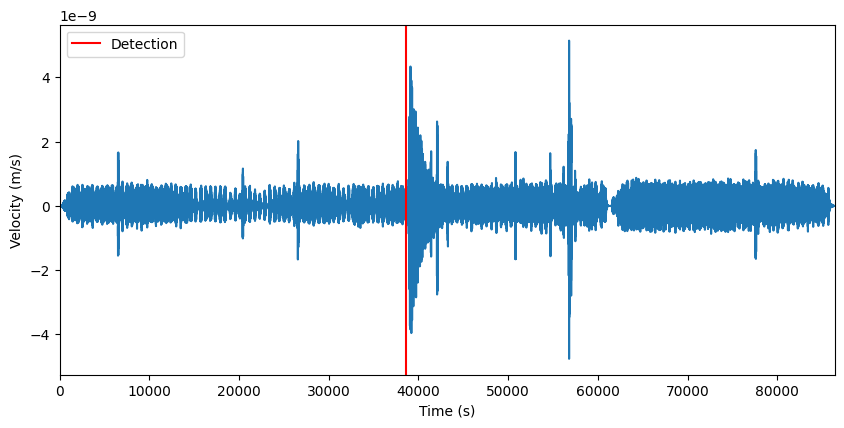

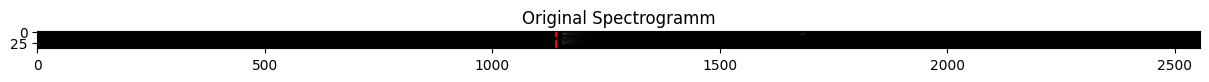

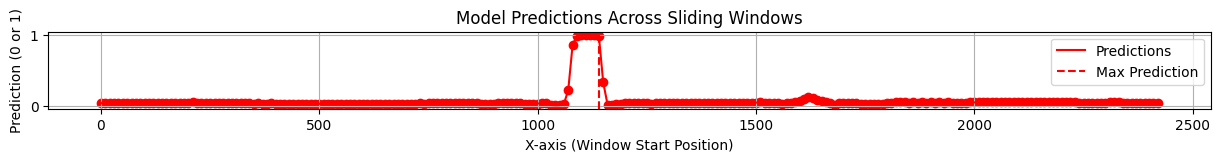

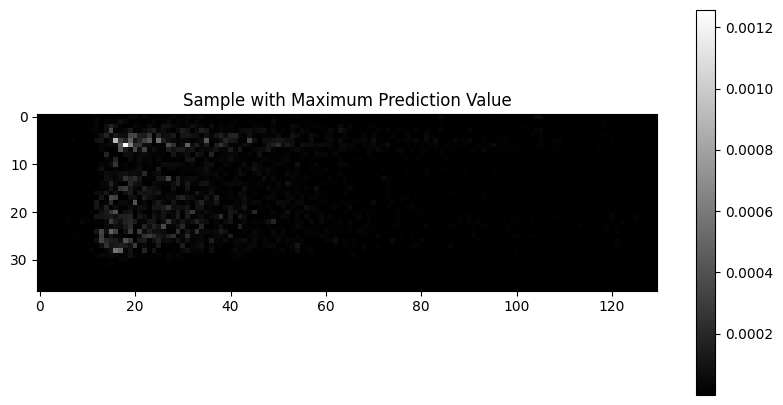

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1780


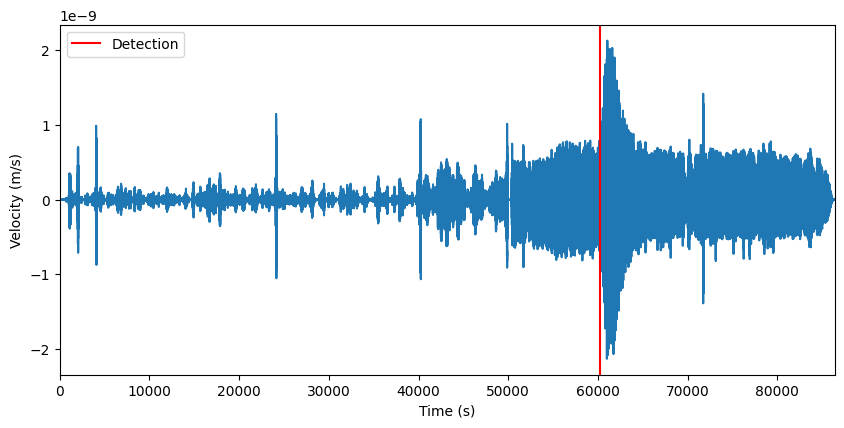

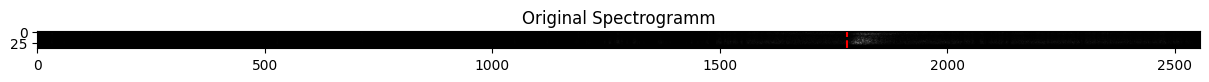

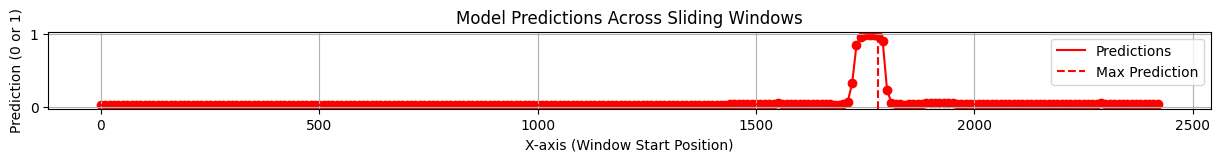

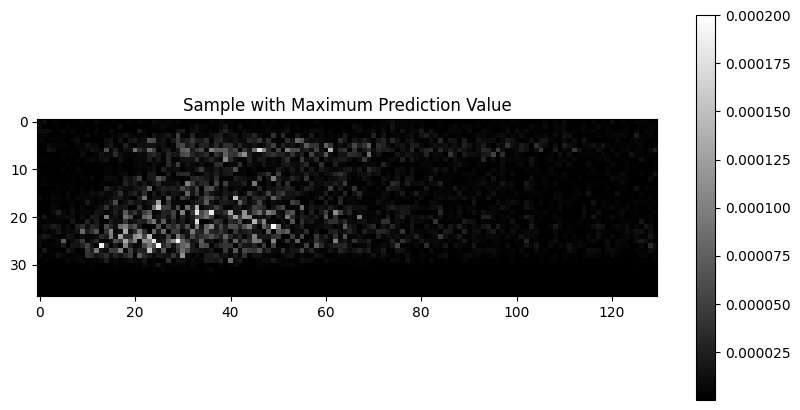

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1390


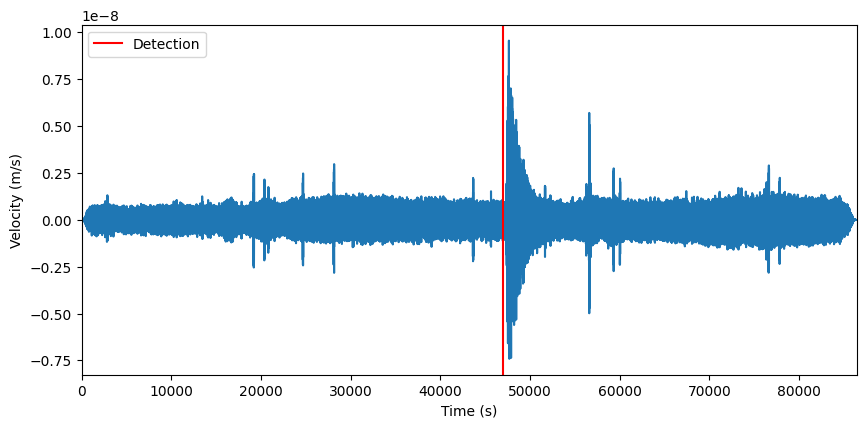

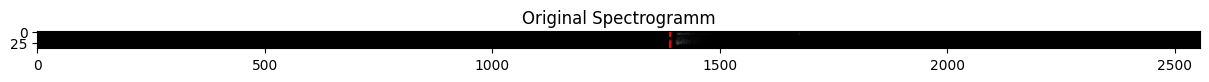

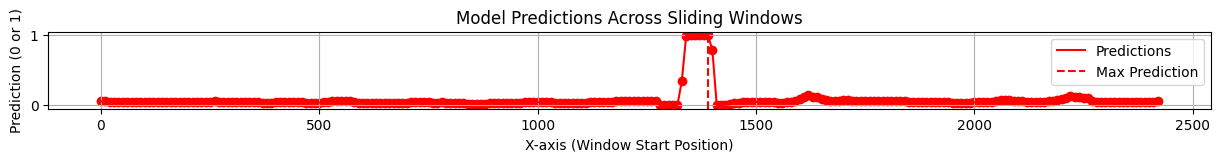

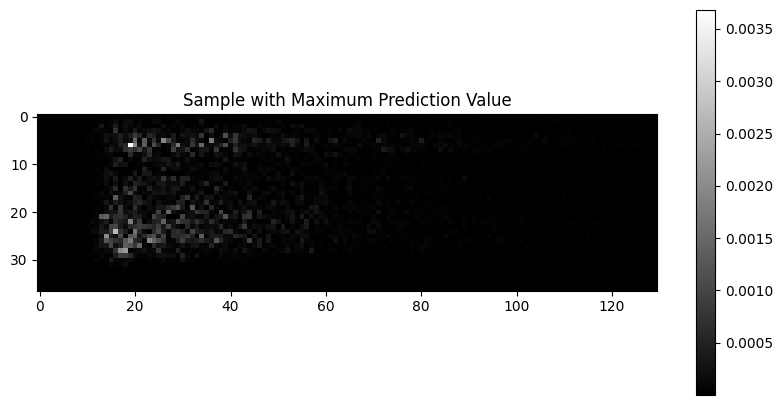

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
480


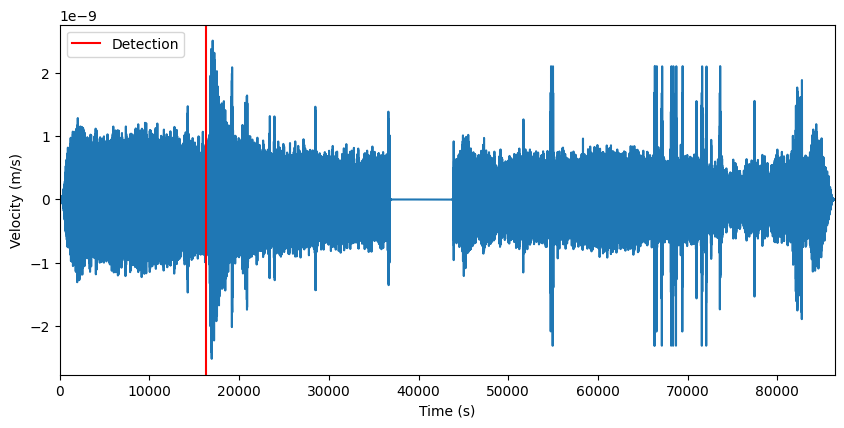

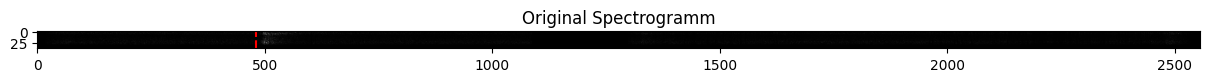

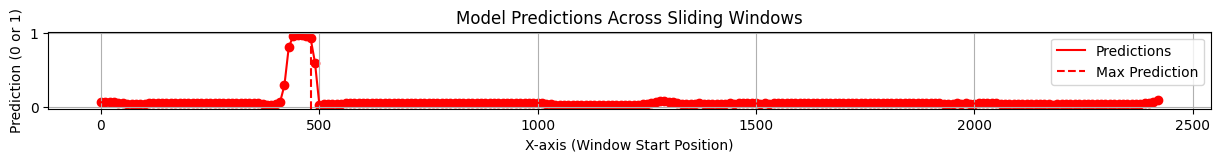

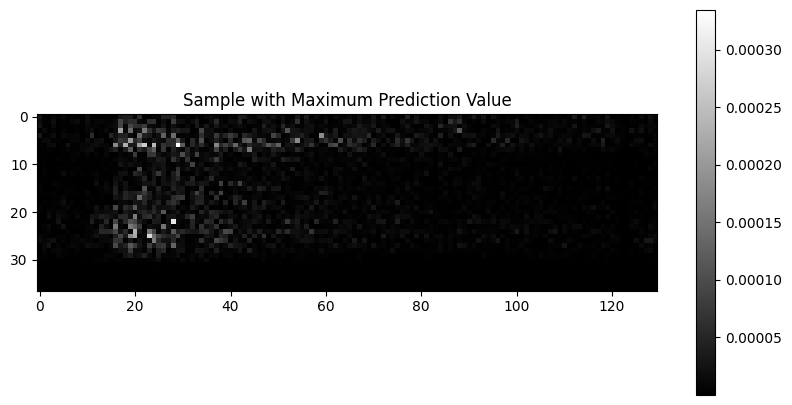

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1270


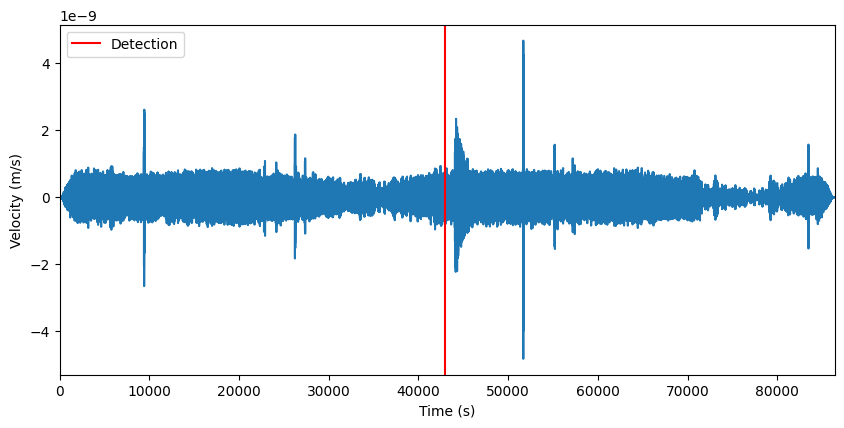

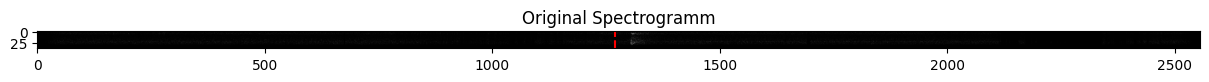

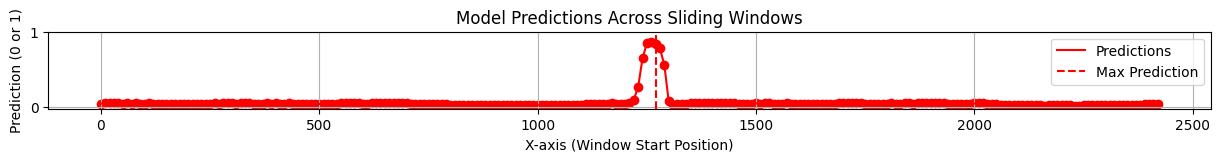

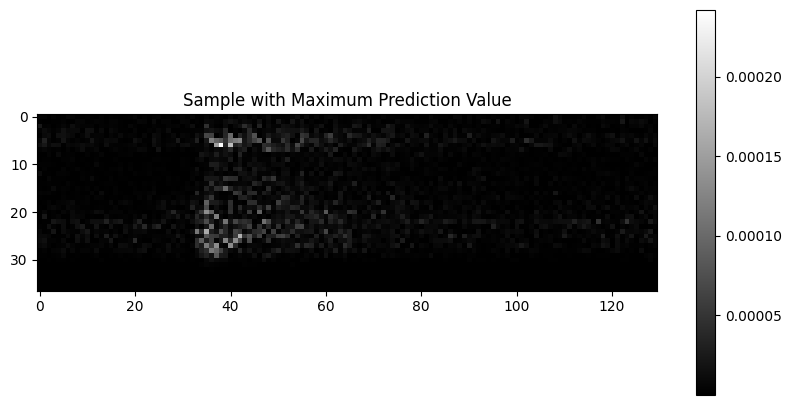

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2260


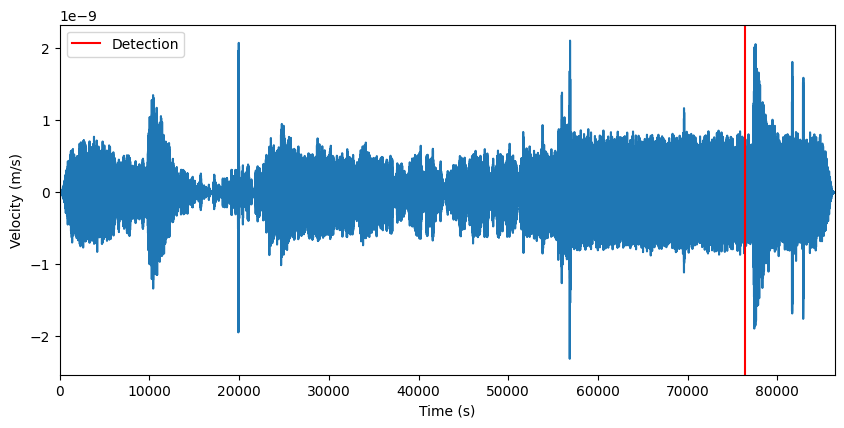

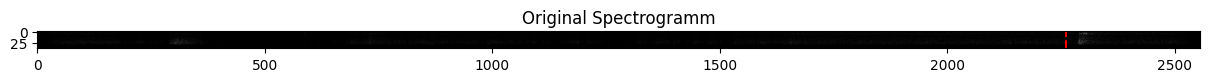

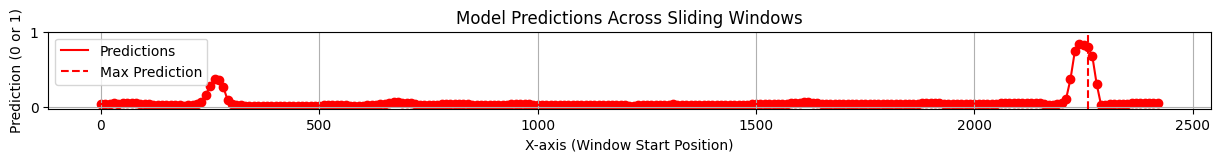

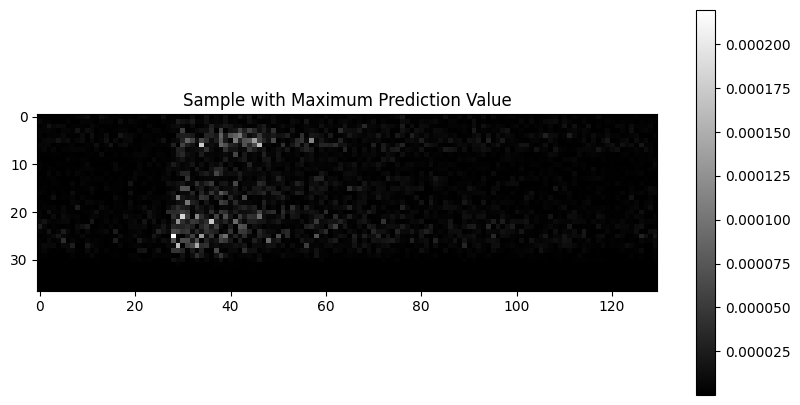

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1610


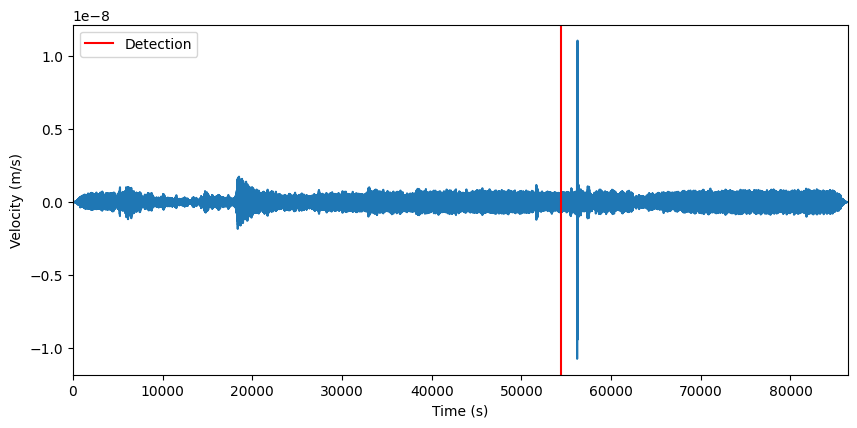

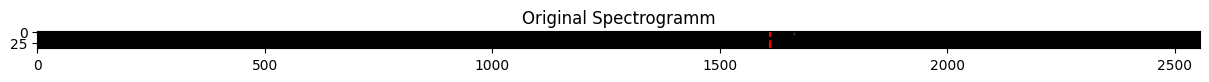

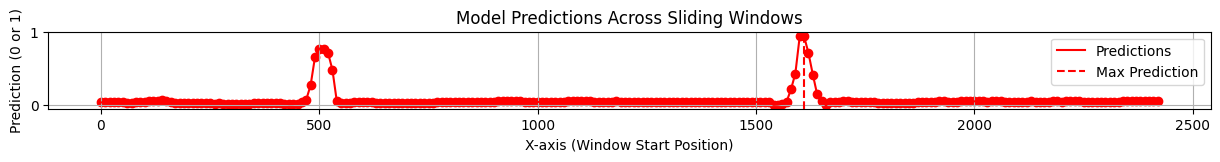

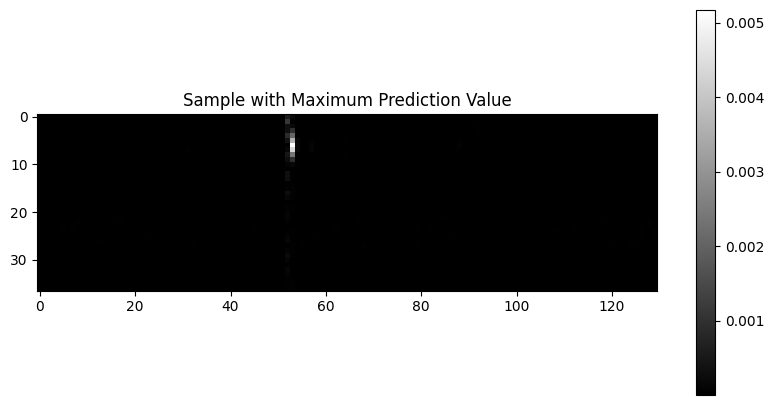

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
50


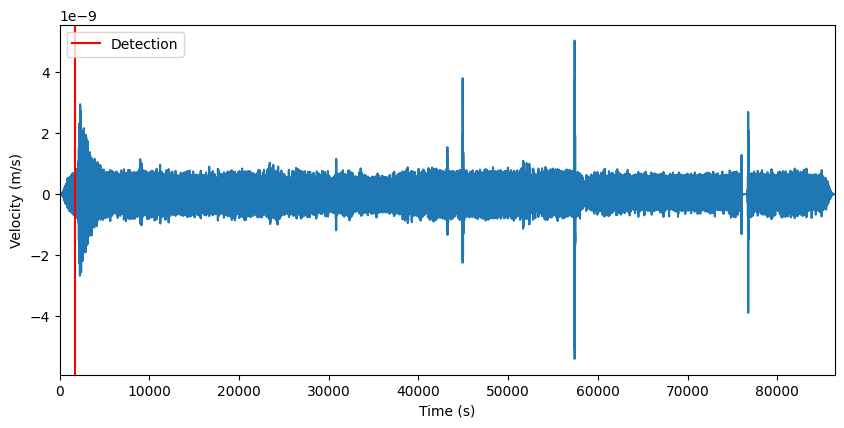

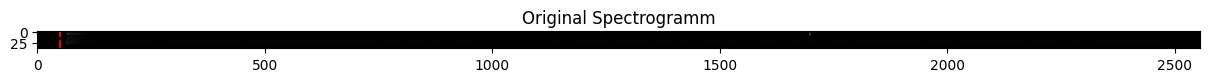

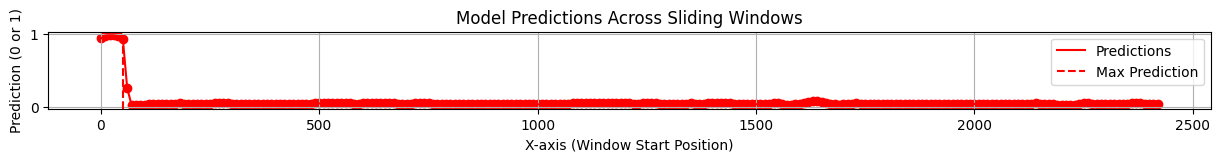

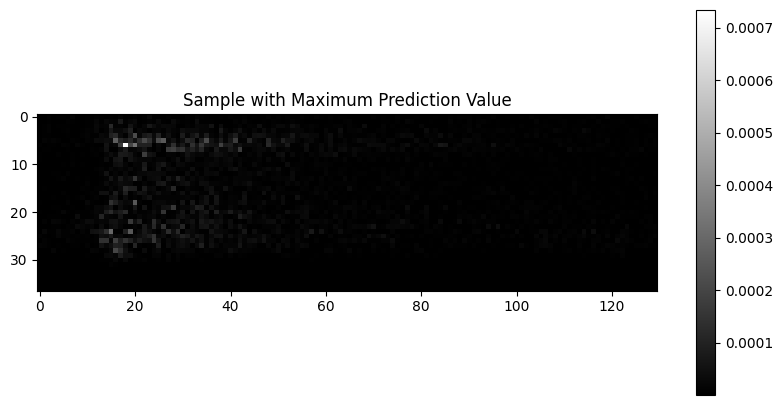

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1240


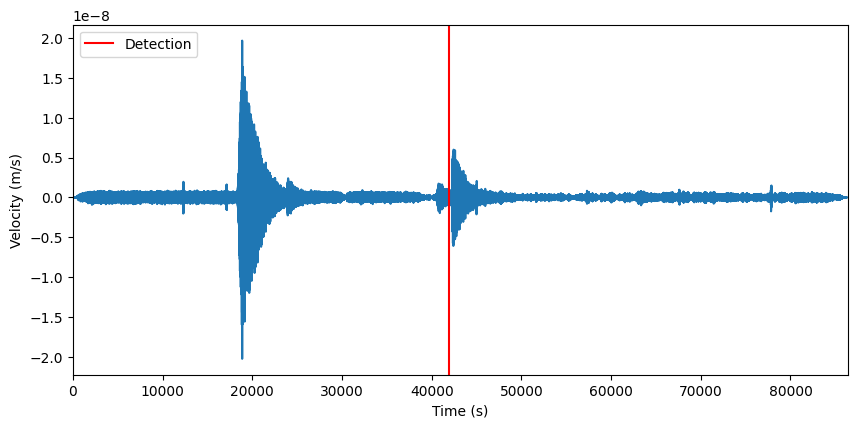

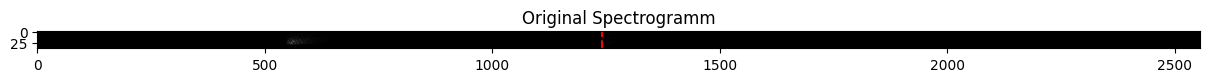

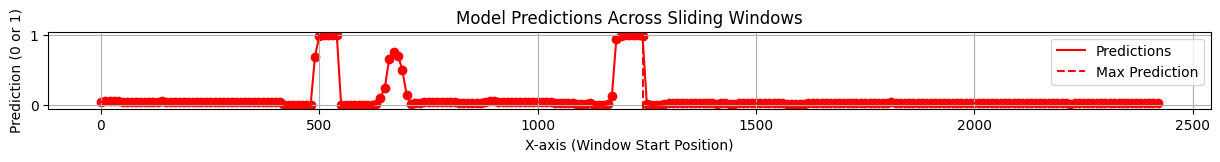

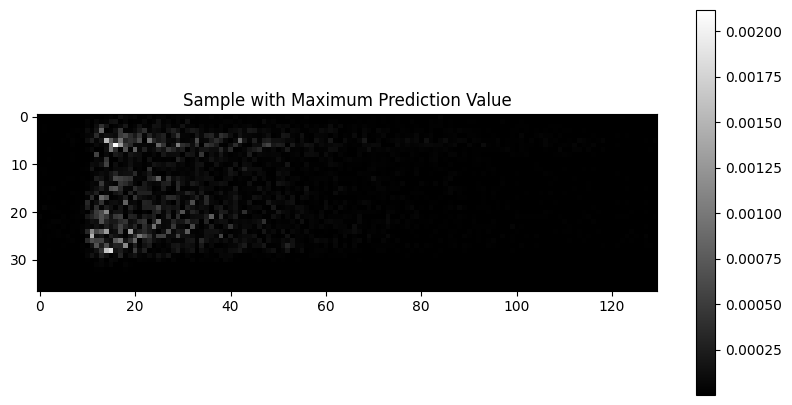

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
400


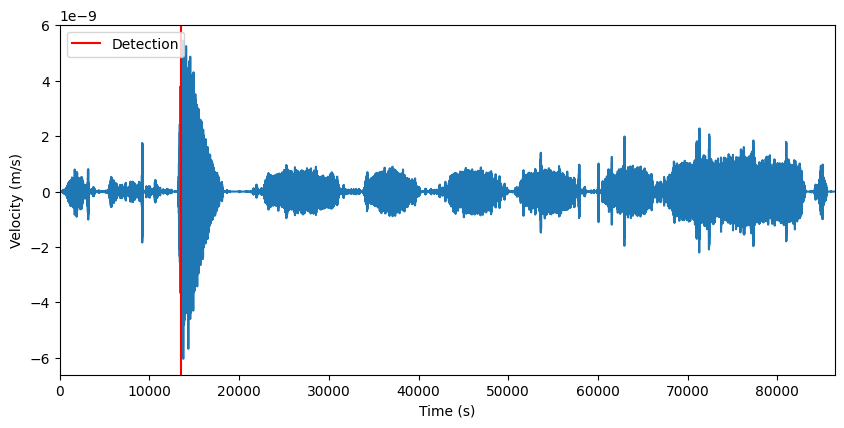

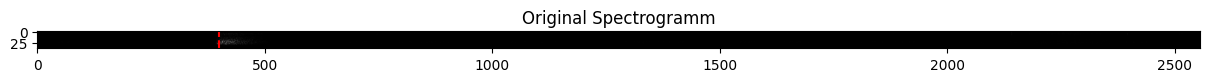

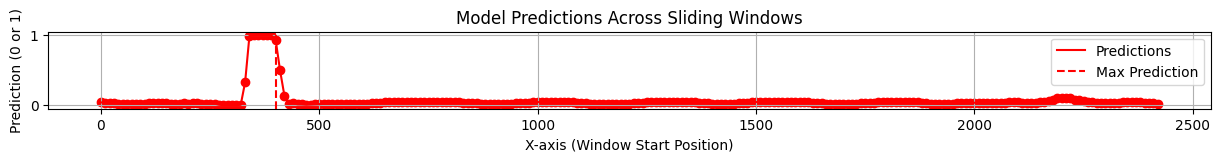

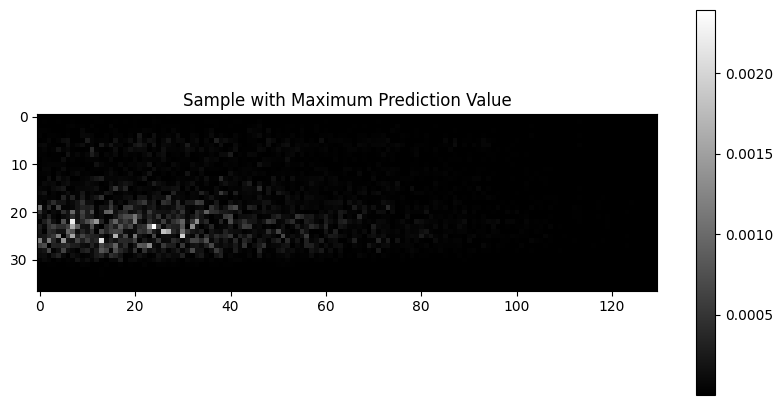

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1270


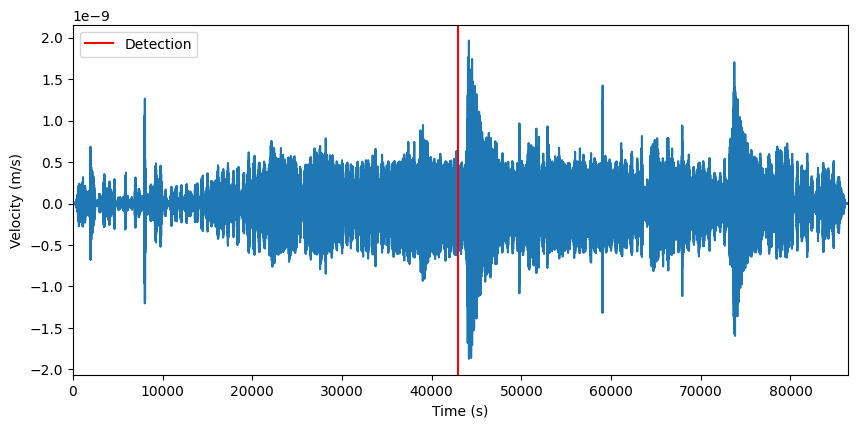

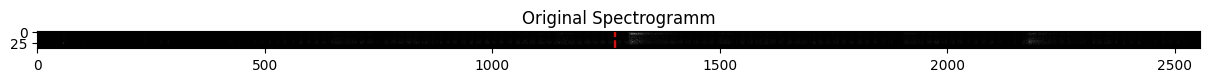

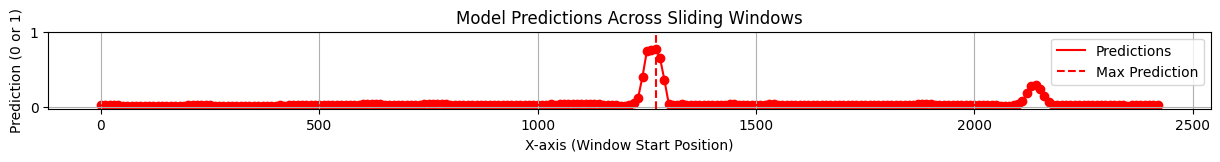

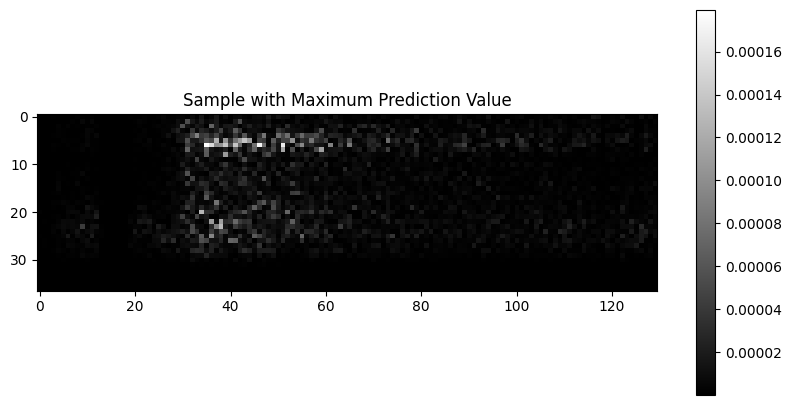

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
530


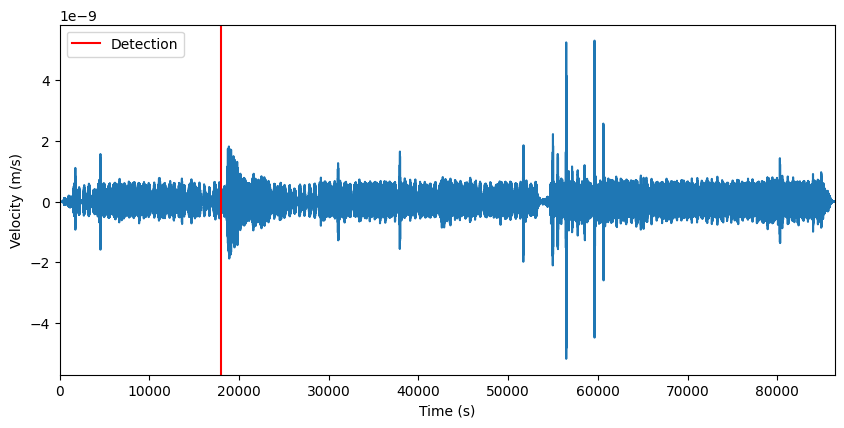

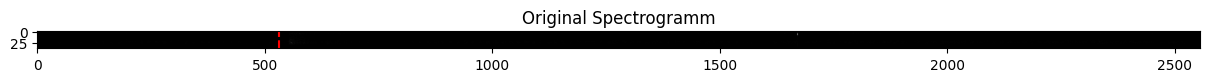

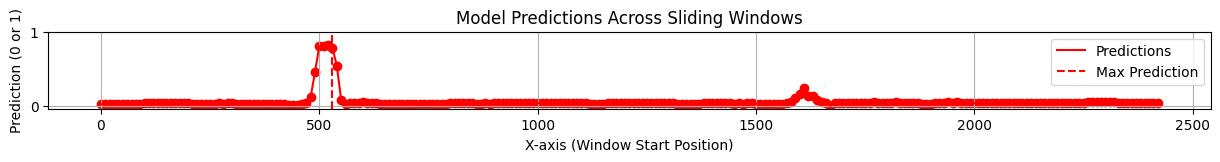

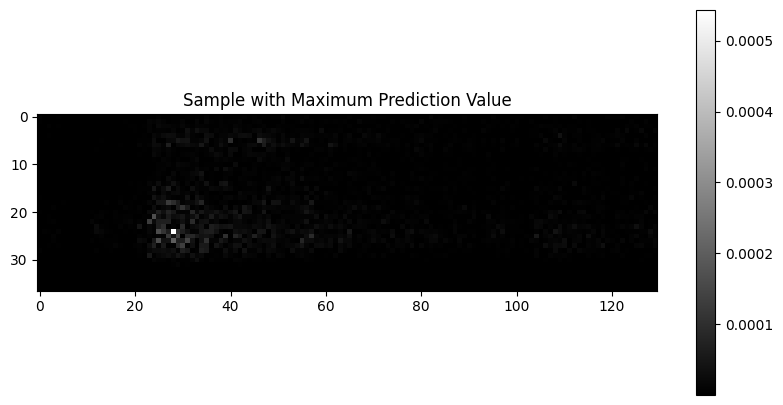

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1830


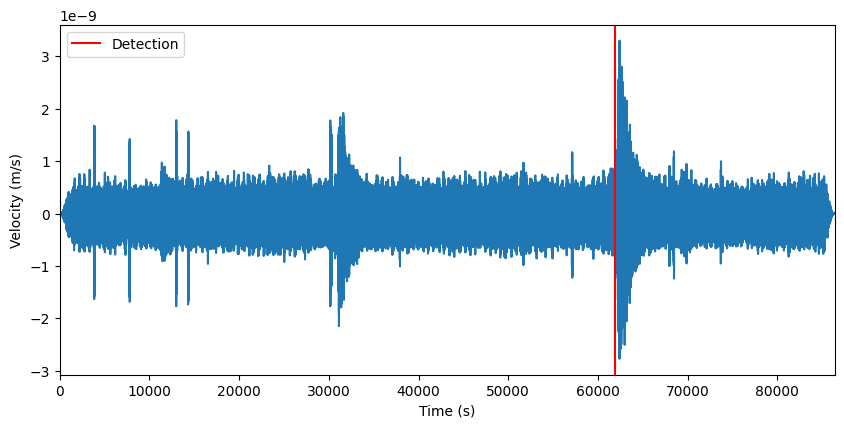

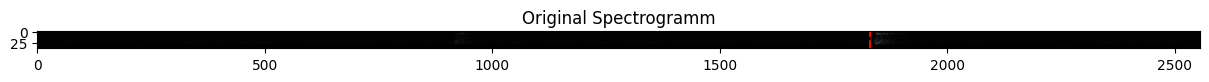

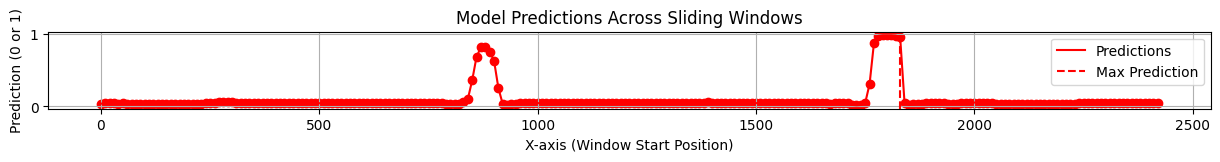

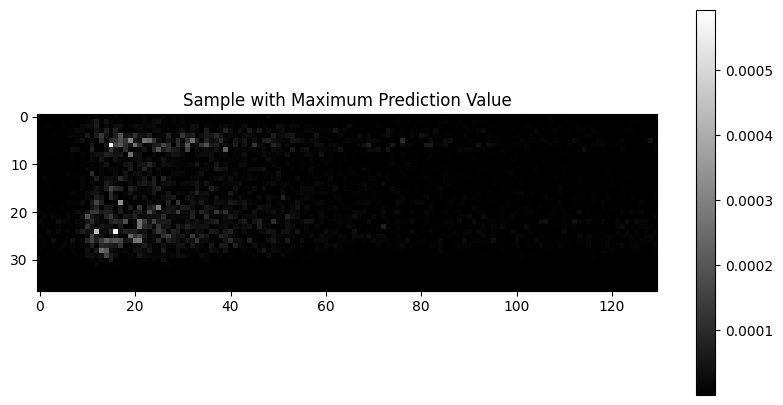

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1830


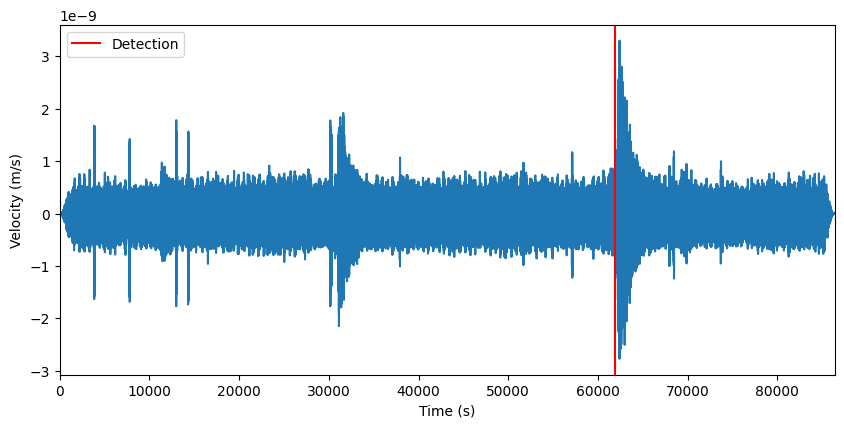

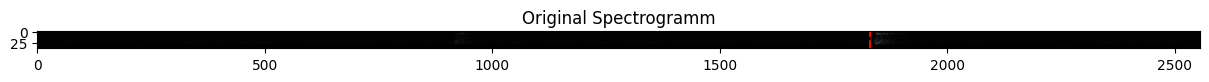

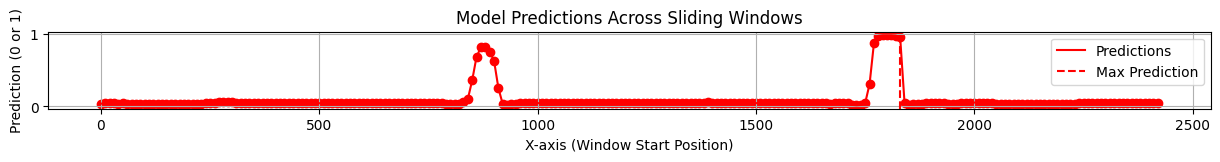

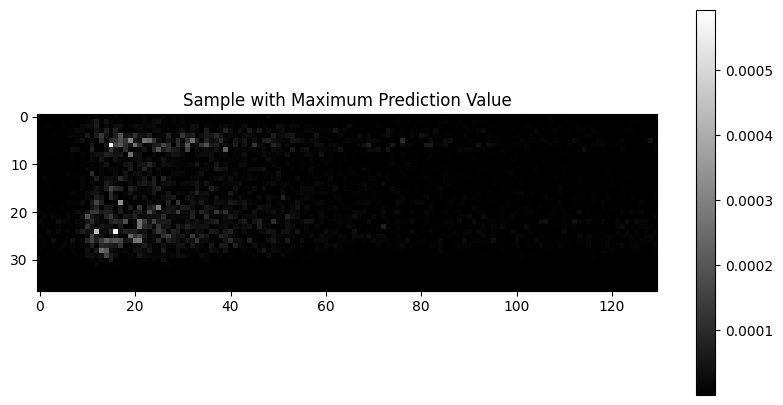

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1170


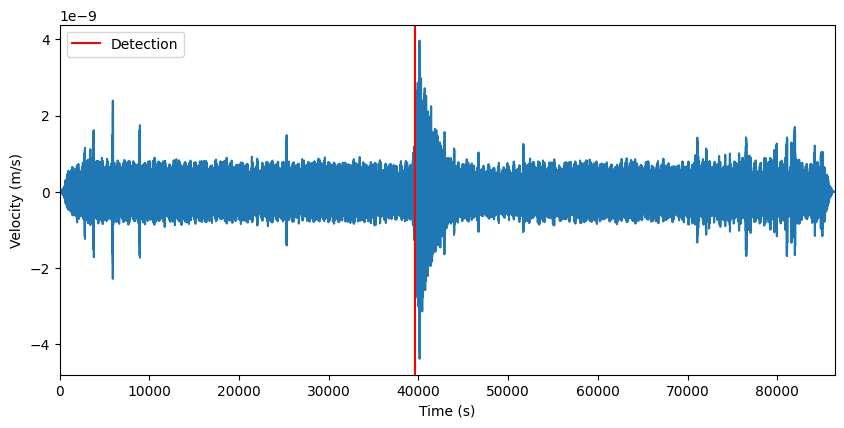

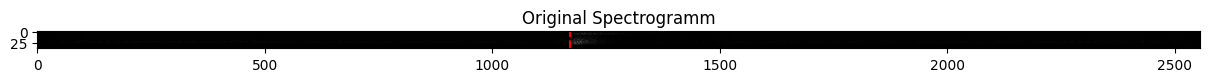

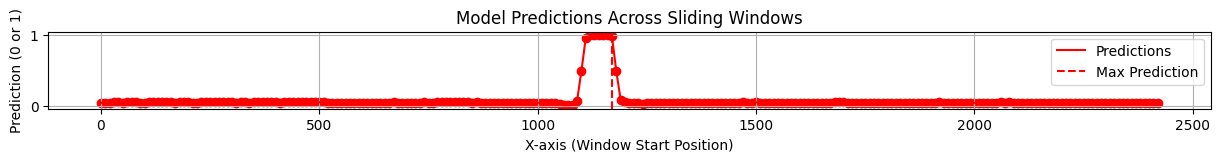

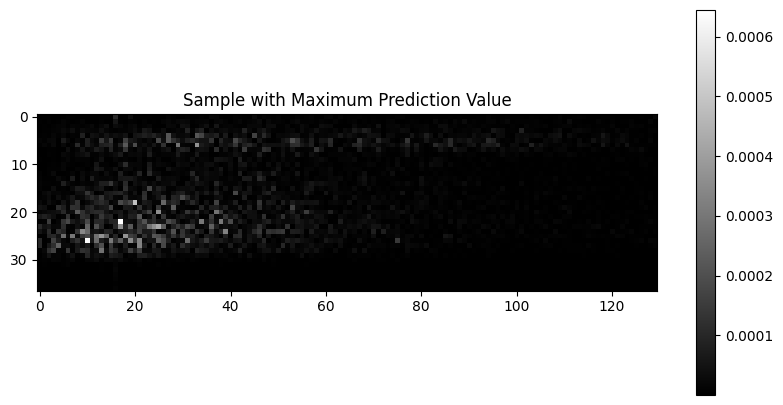

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.18427170e+04, 8.18765283e+04, 8.19103396e+04])]
90


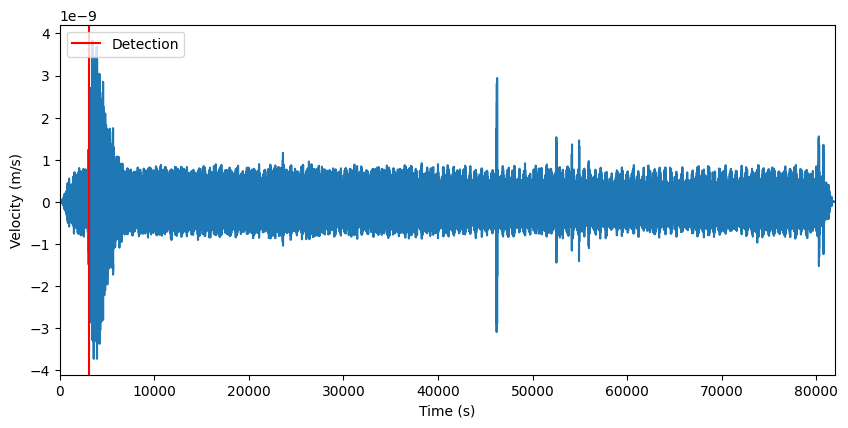

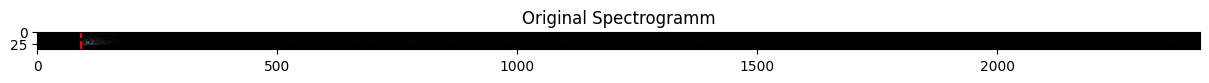

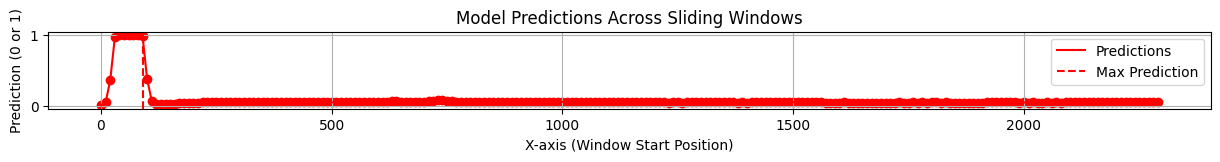

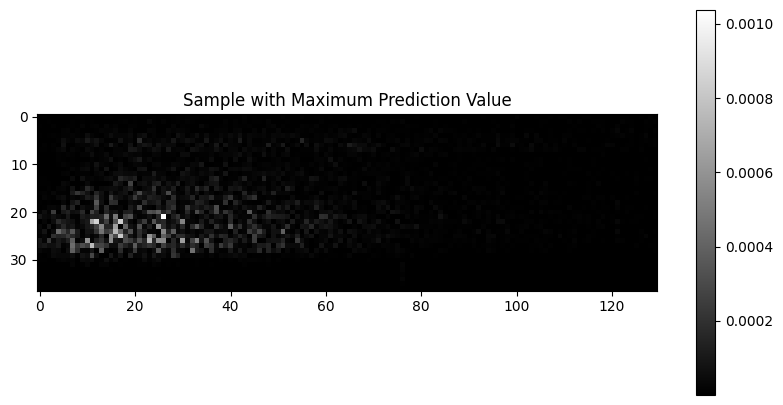

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1900


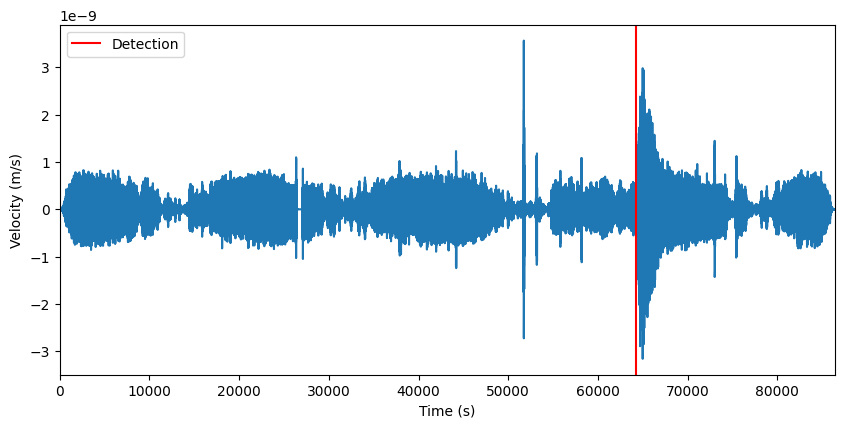

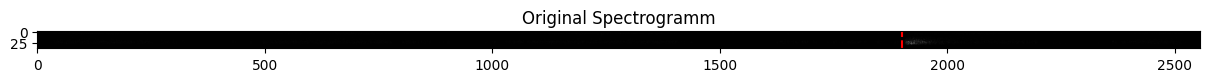

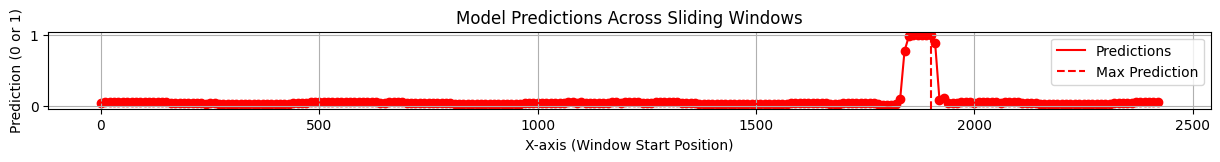

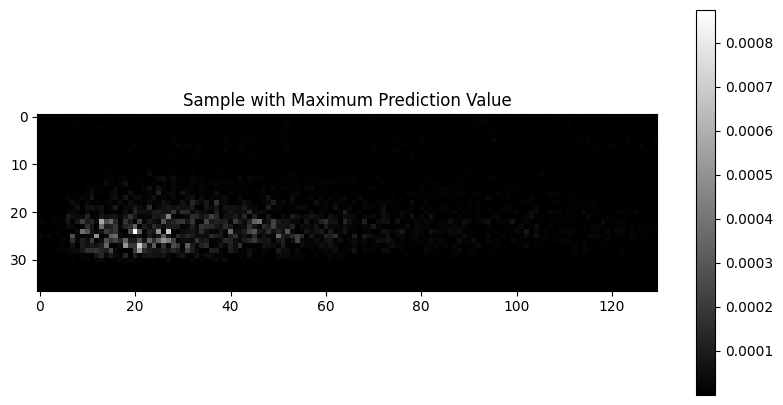

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
840


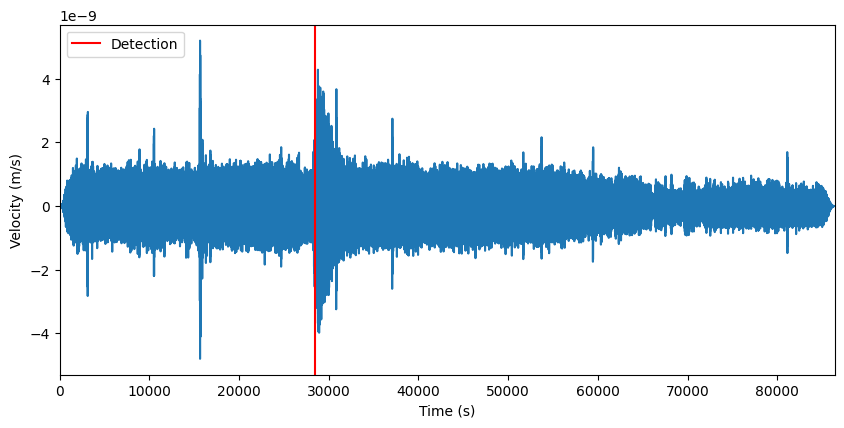

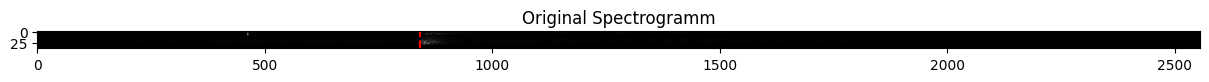

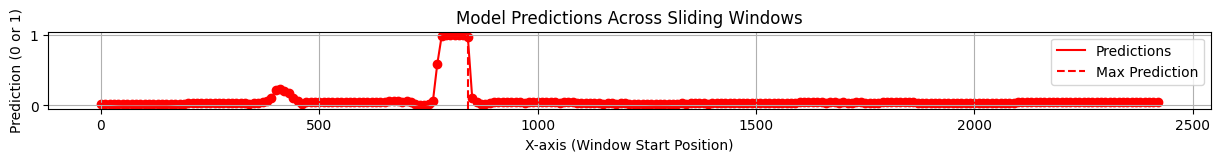

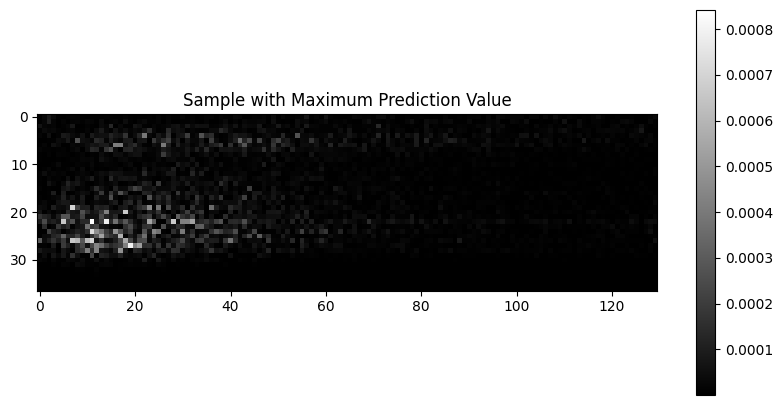

Number of positive samples: 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       4.01195472e+04, 4.01533585e+04, 4.01871698e+04])]
780


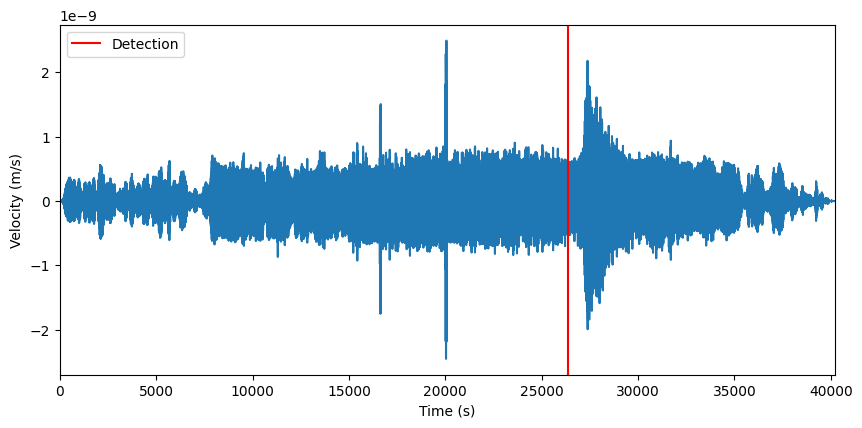

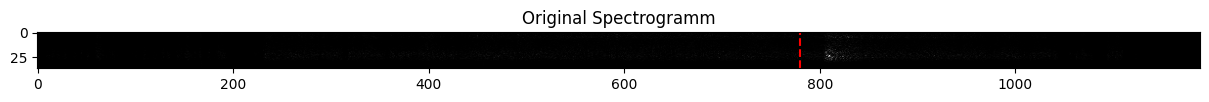

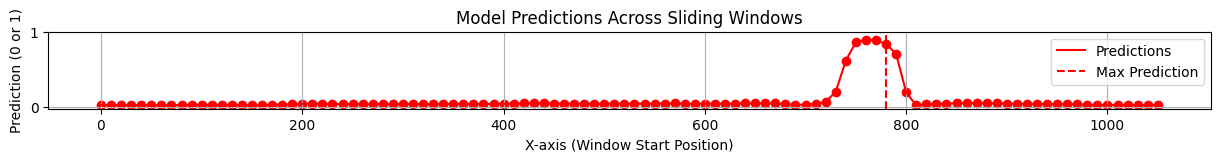

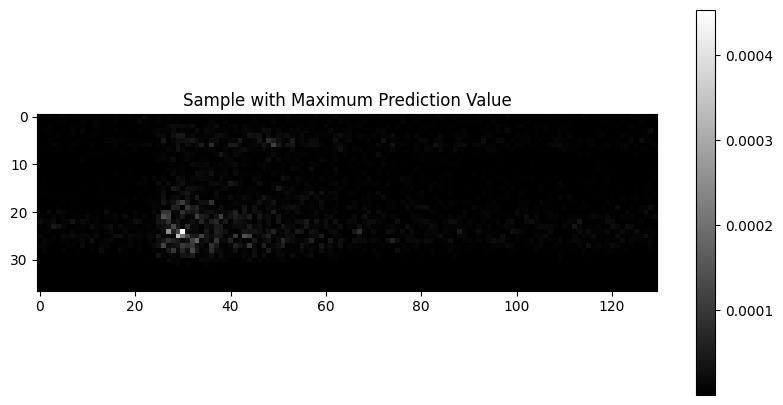

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1900


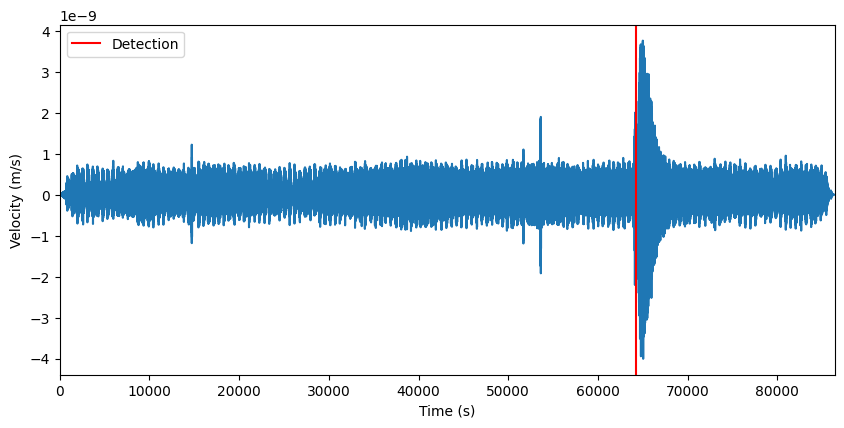

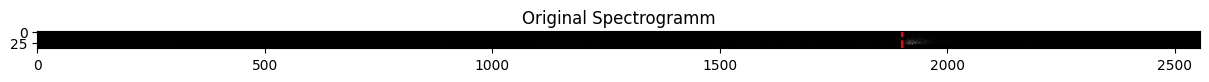

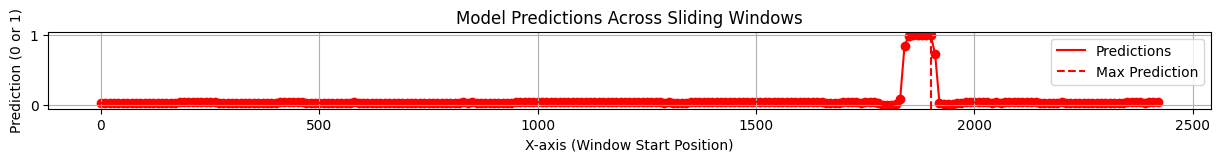

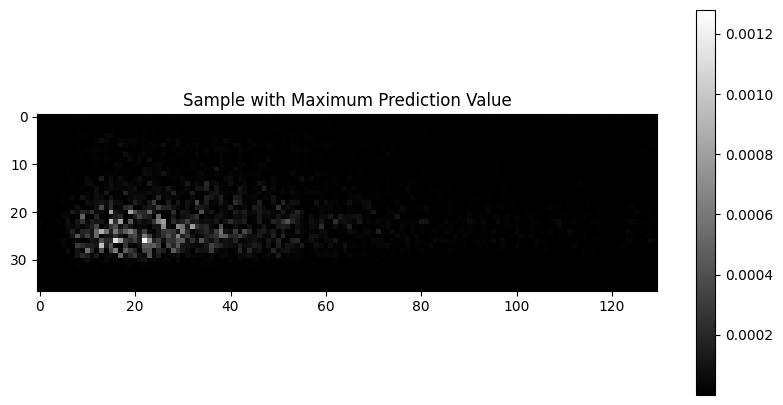

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1480


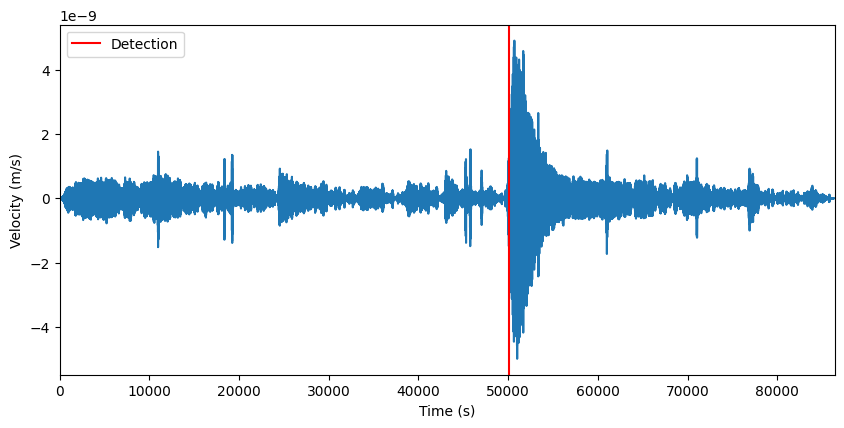

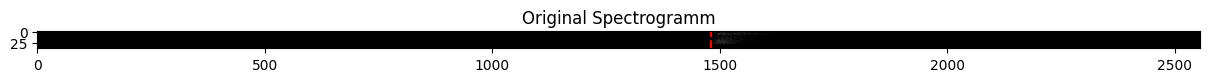

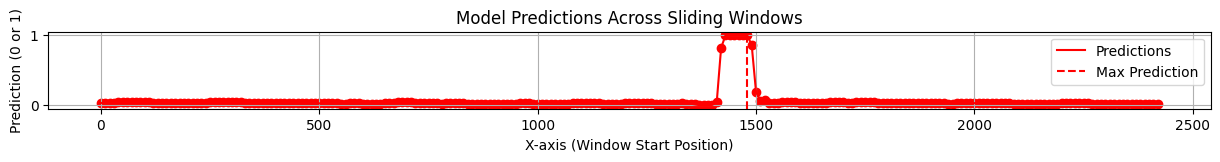

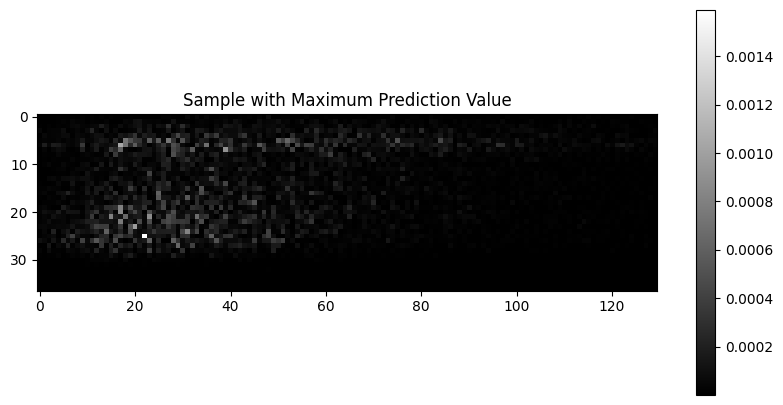

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2010


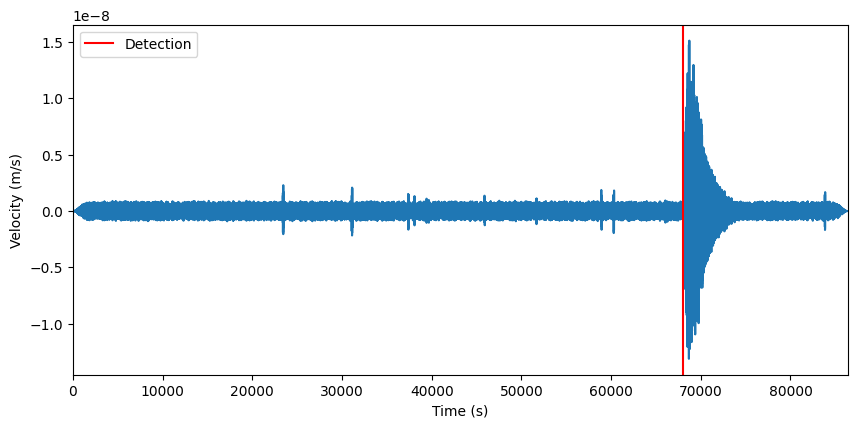

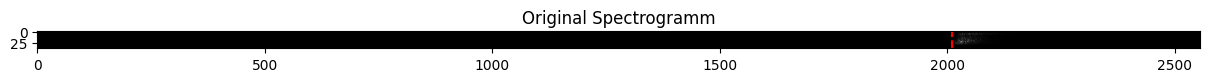

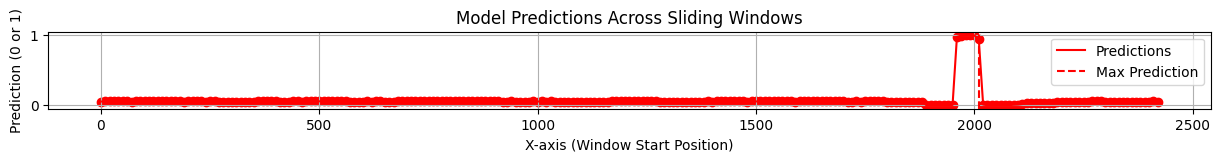

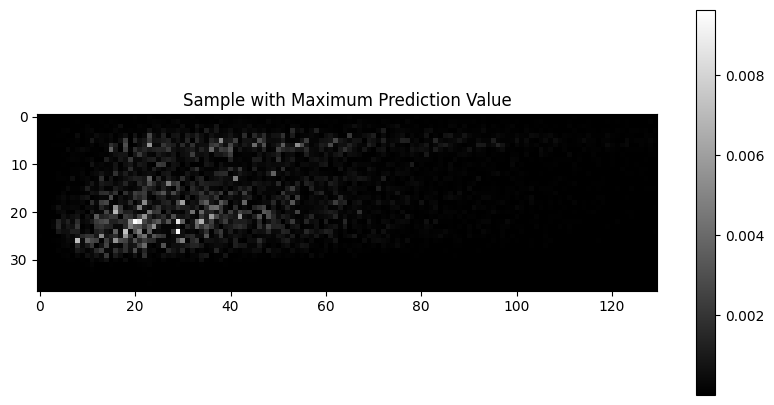

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1830


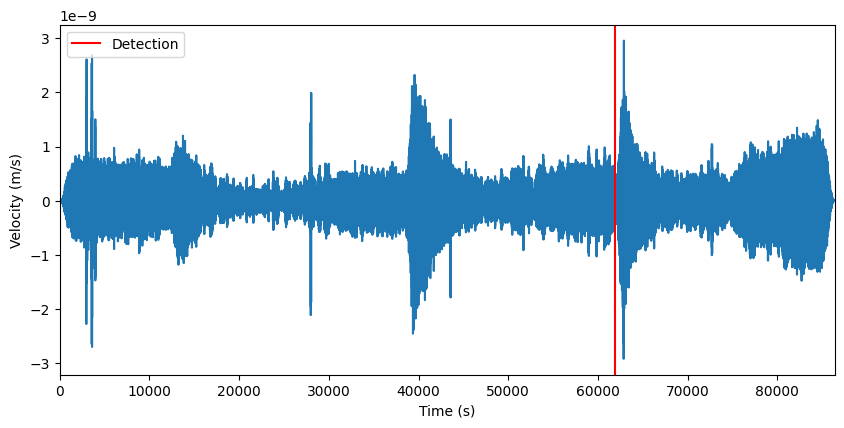

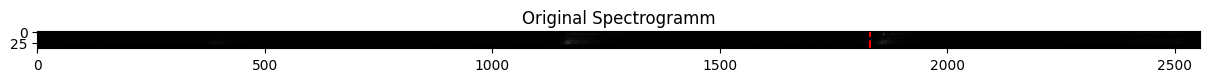

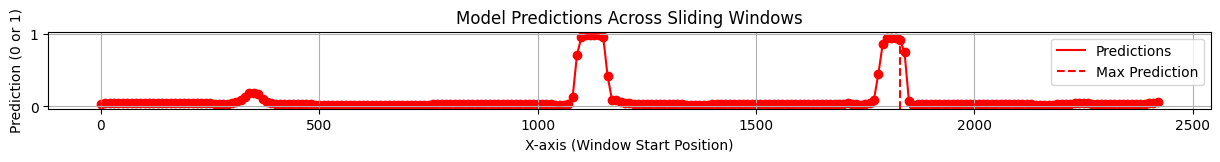

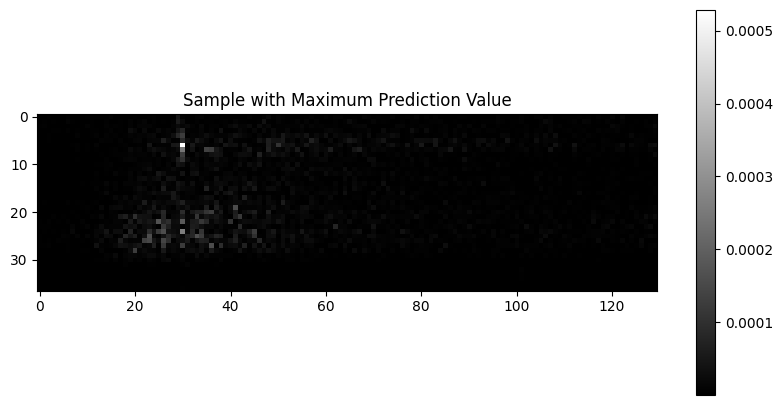

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1830


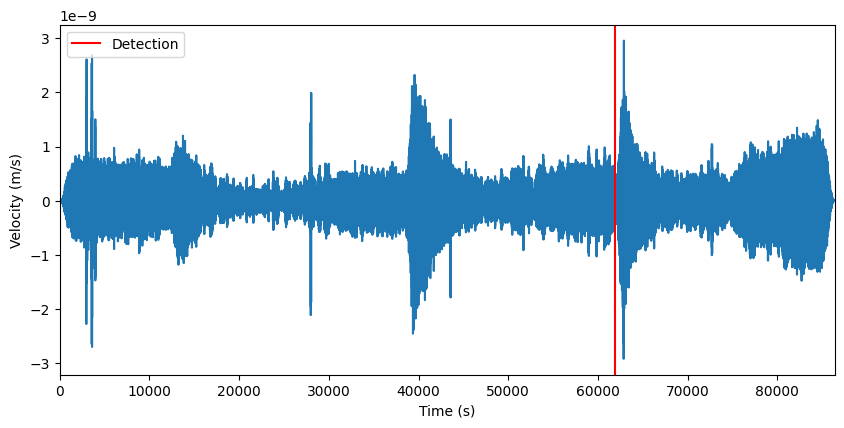

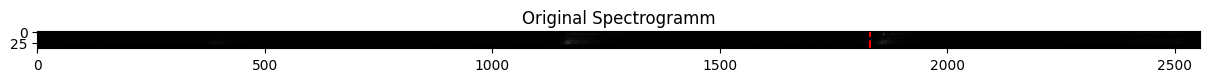

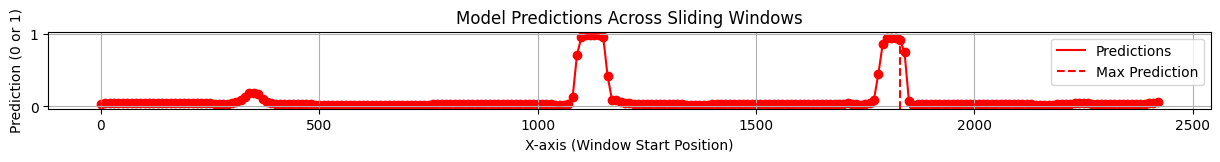

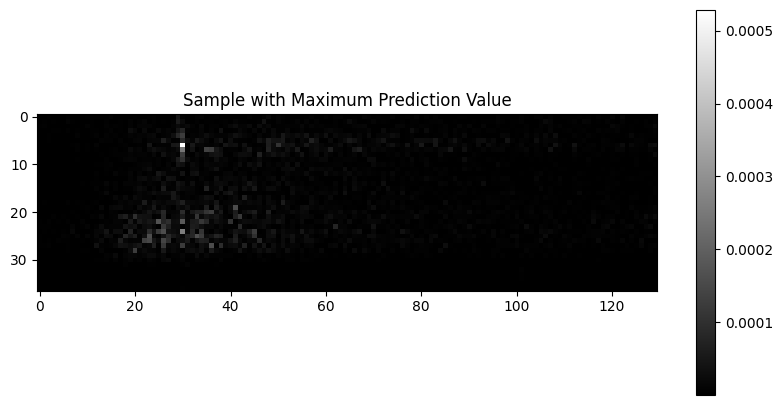

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
500


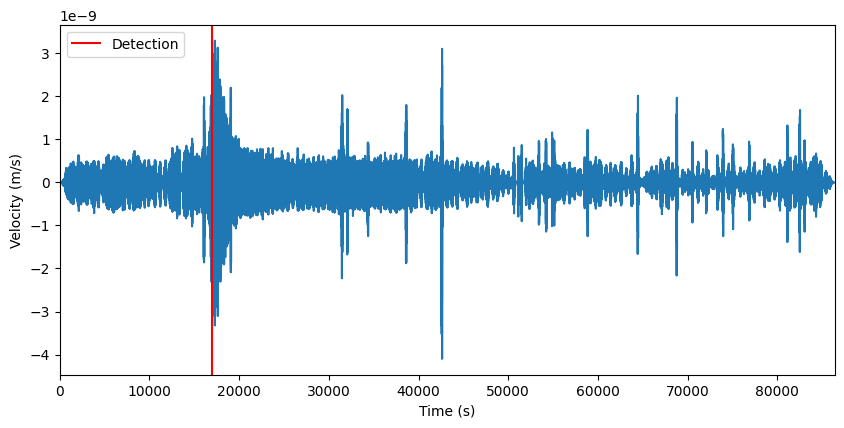

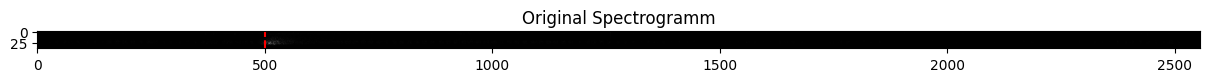

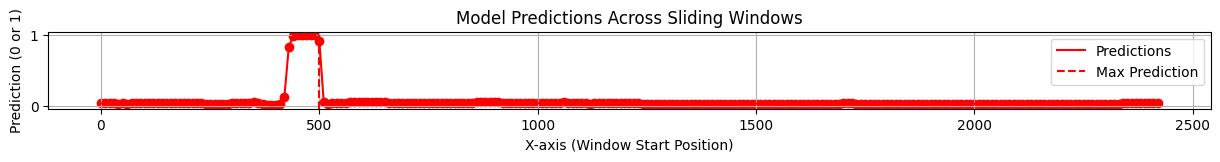

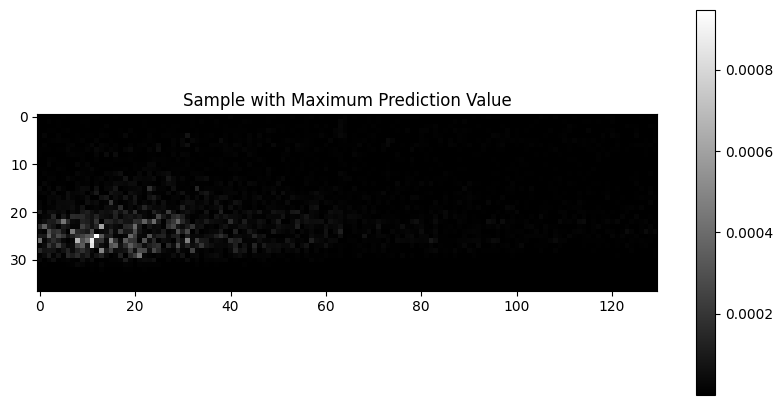

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
550


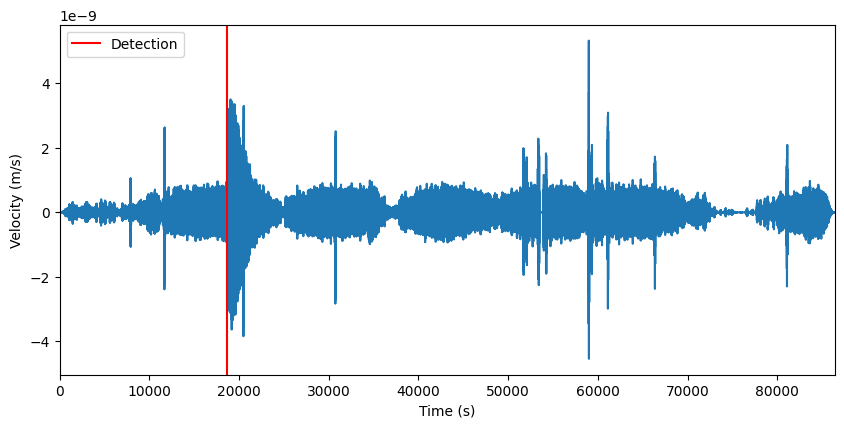

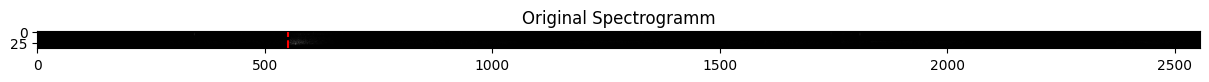

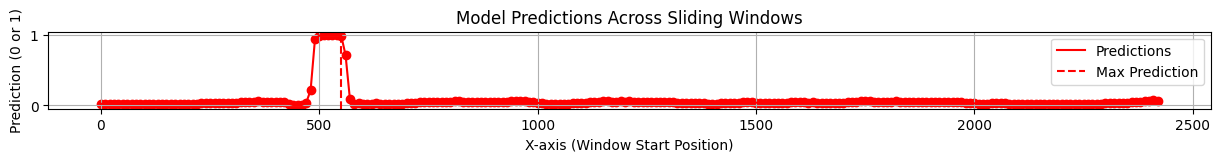

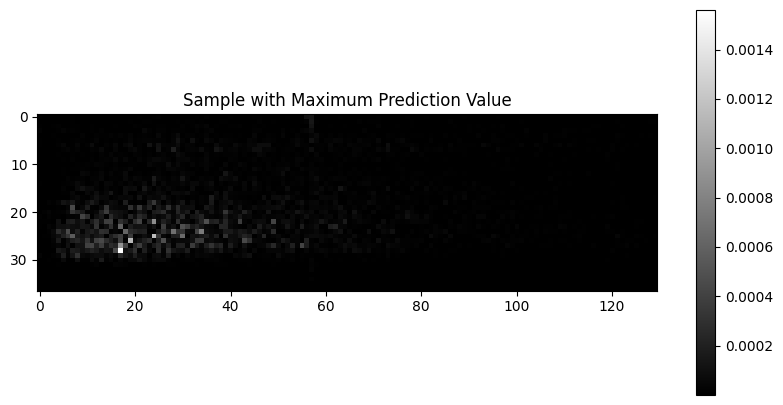

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2210


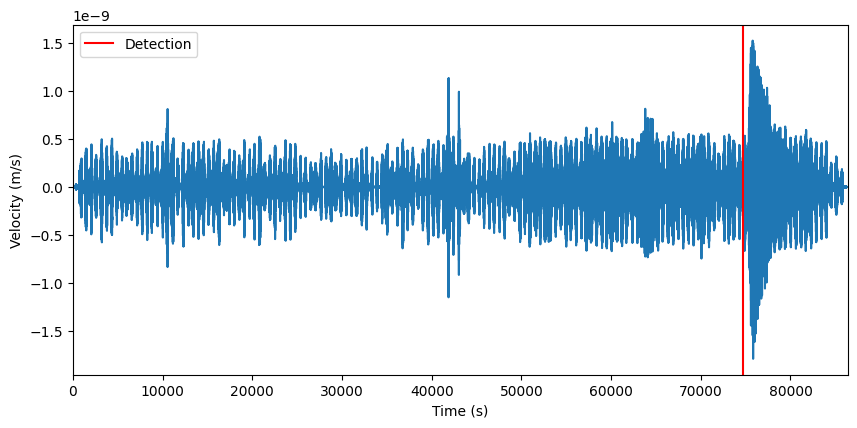

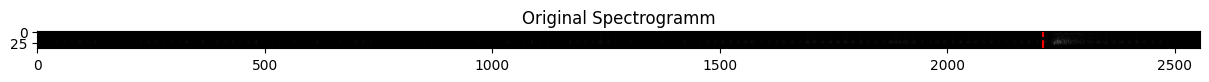

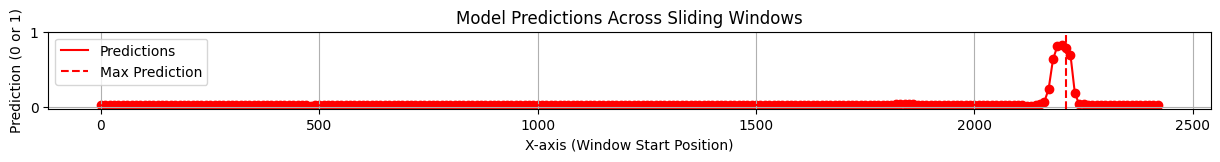

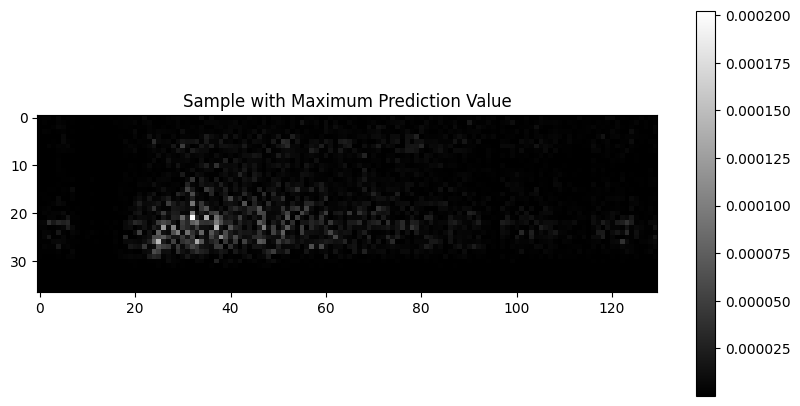

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1340


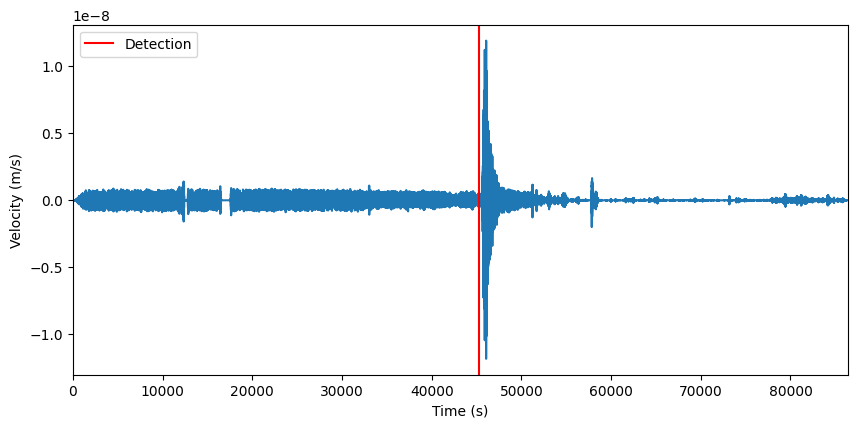

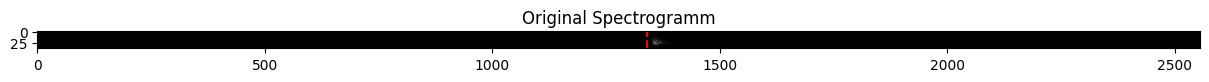

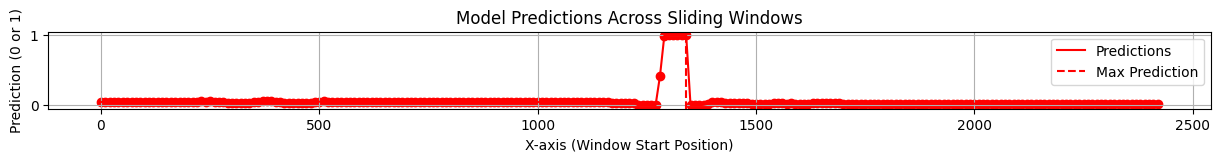

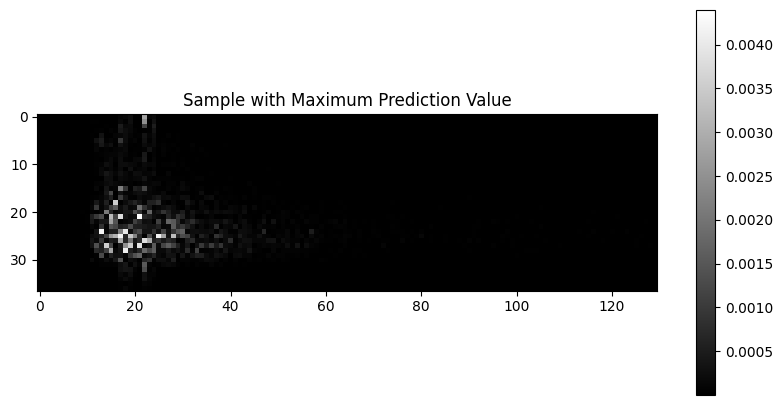

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1820


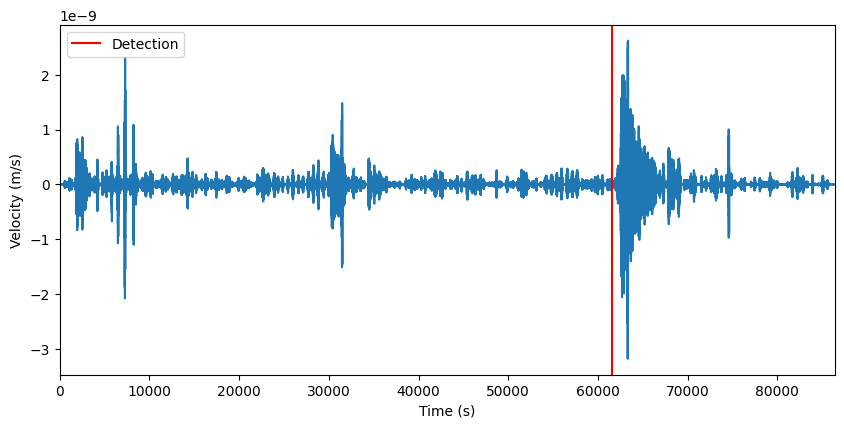

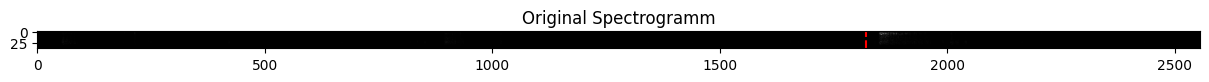

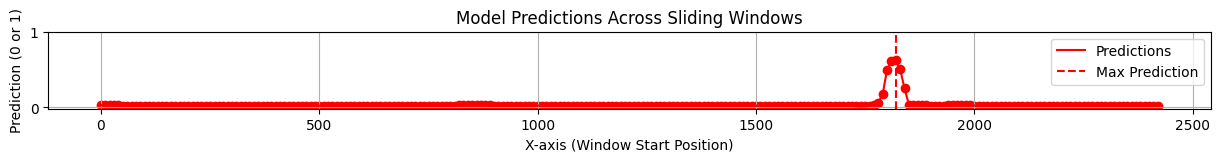

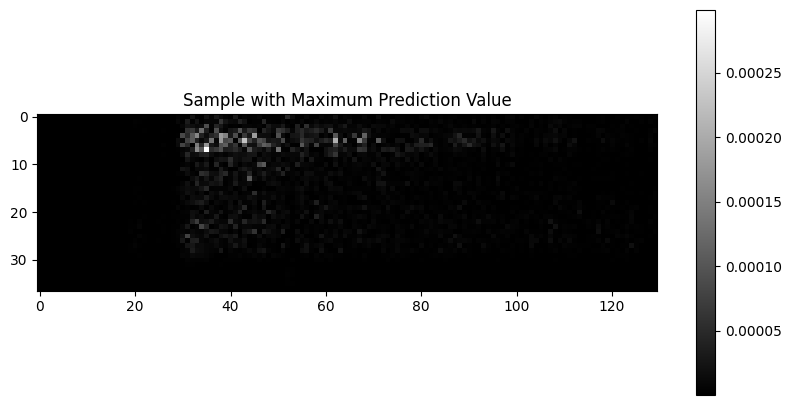

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2420


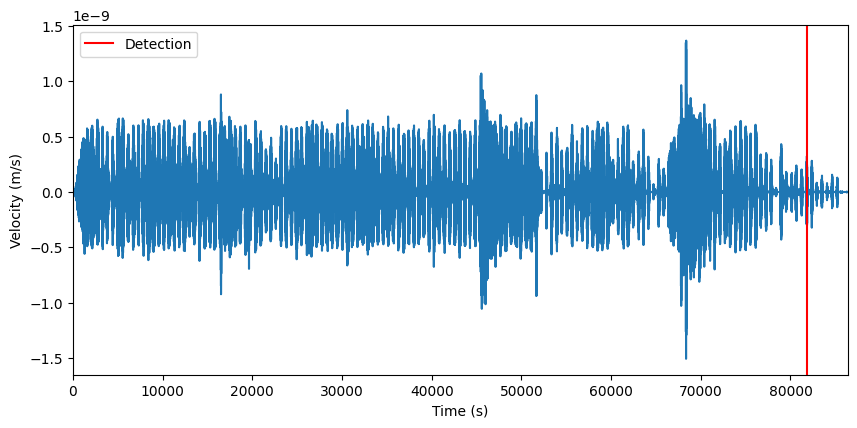

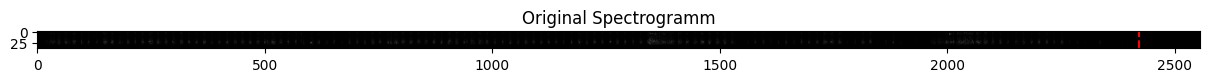

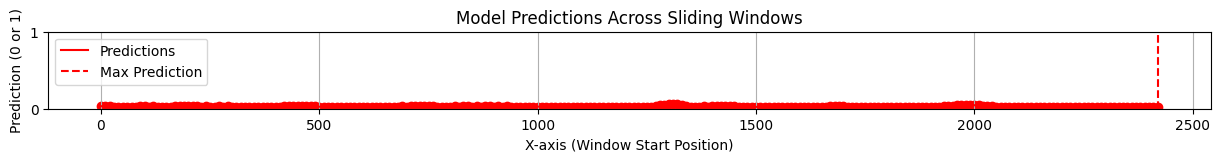

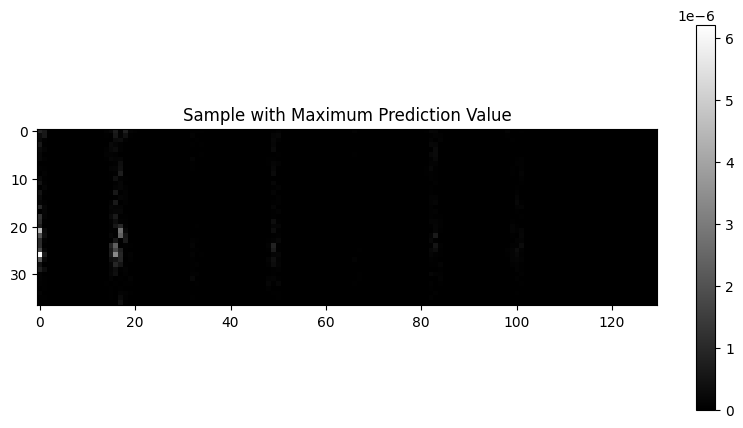

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2070


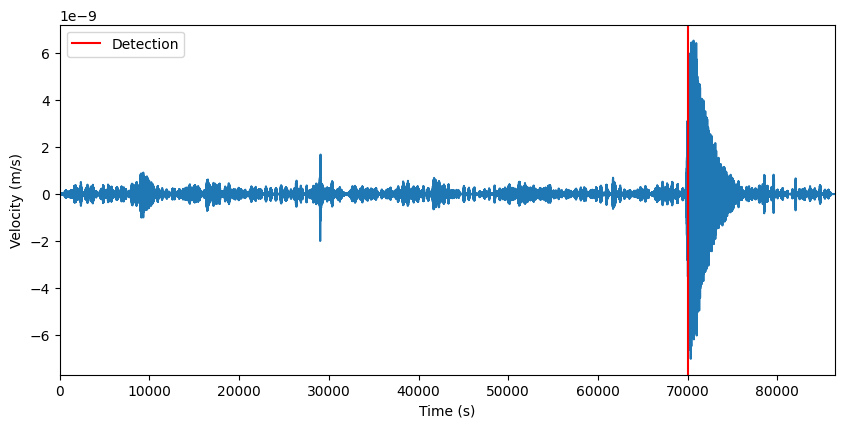

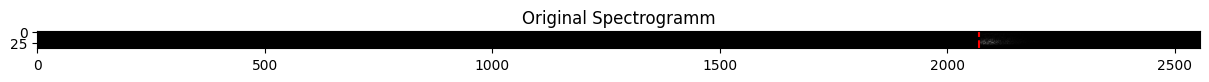

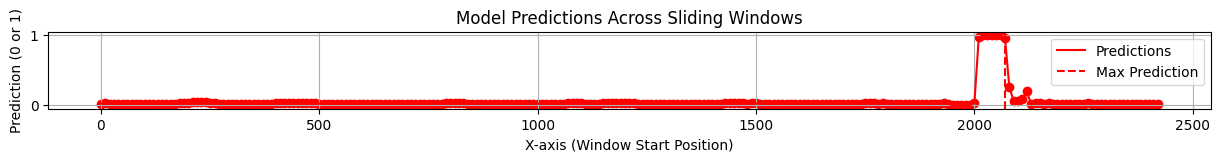

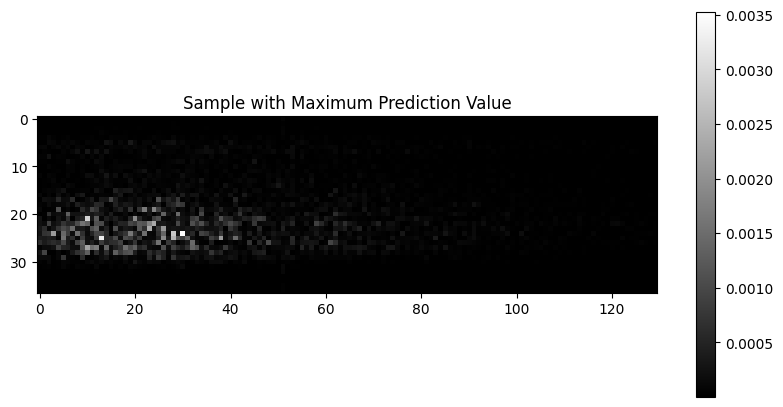

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1960


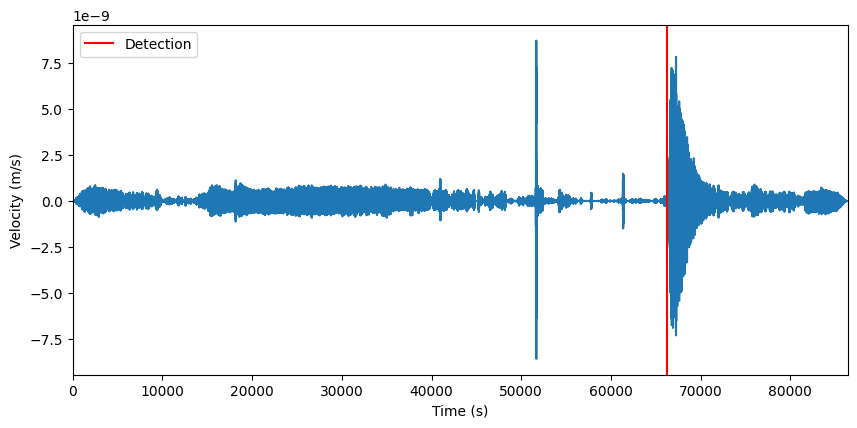

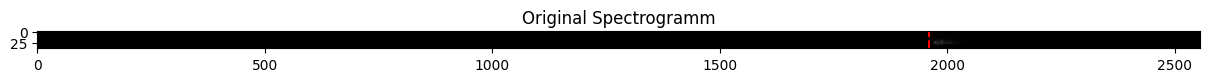

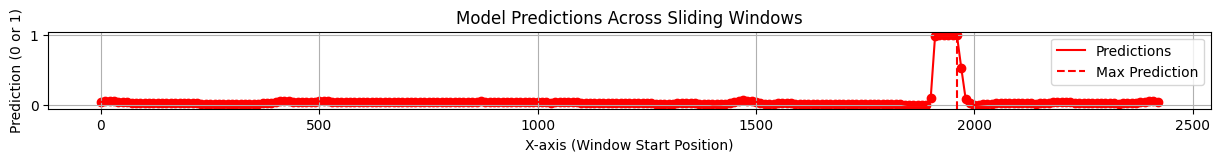

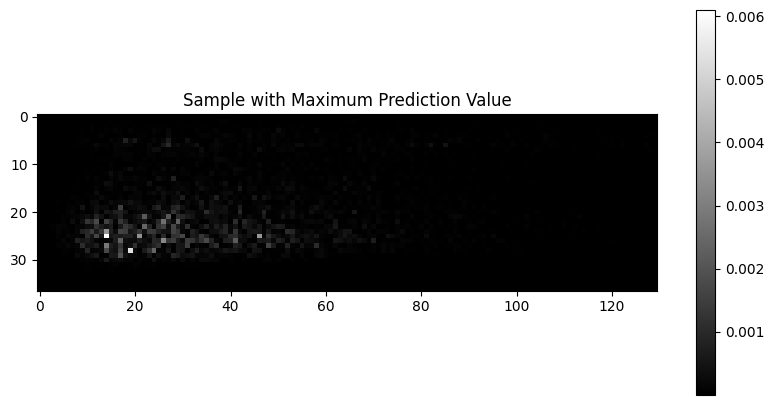

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2320


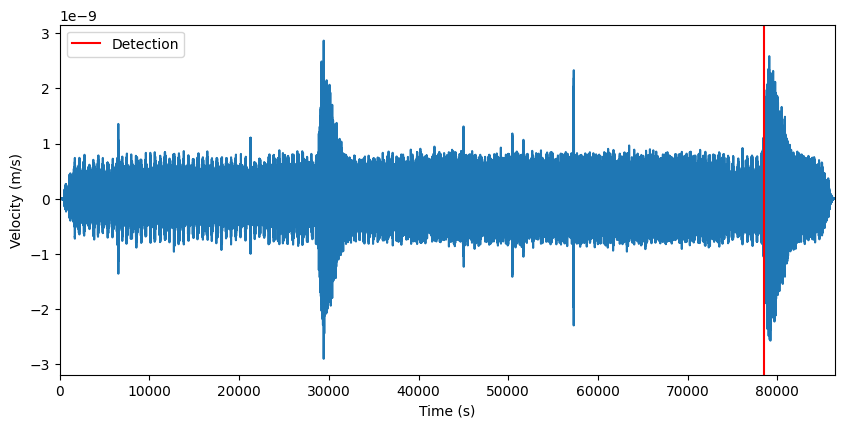

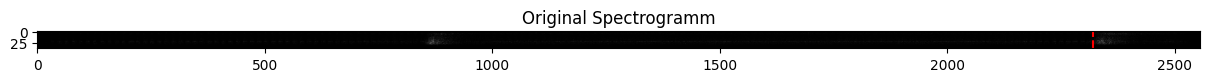

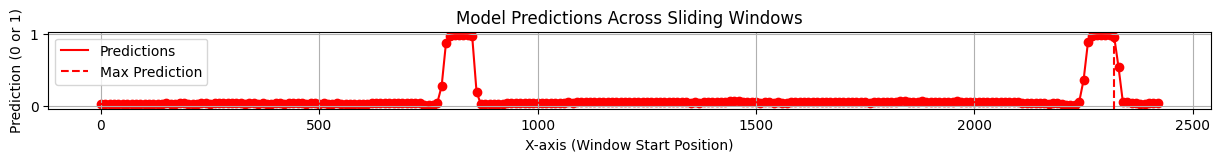

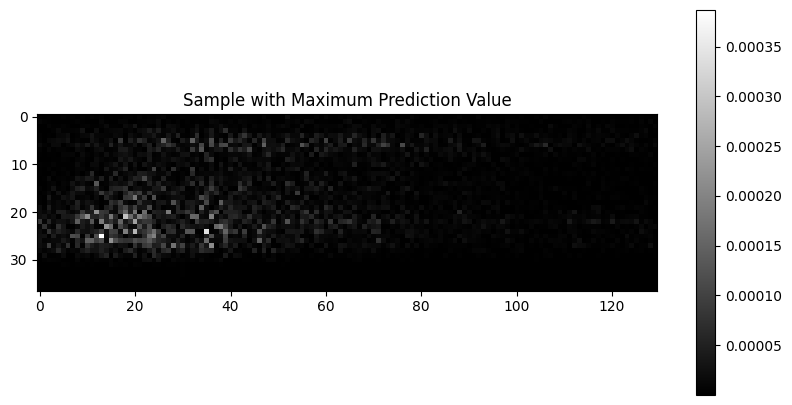

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1520


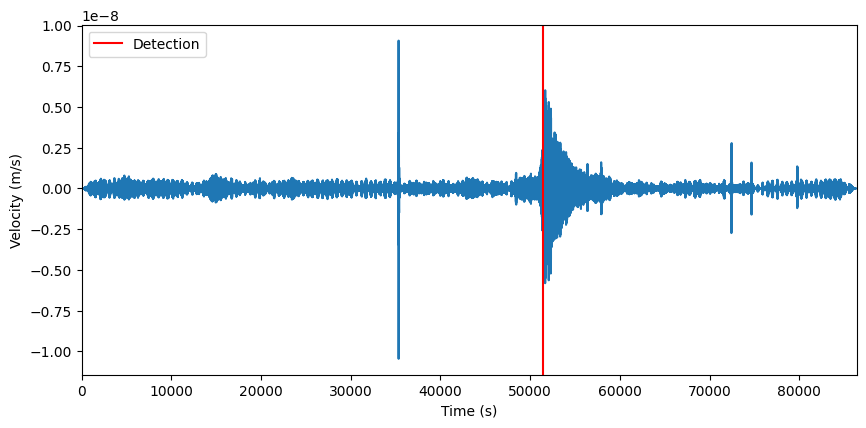

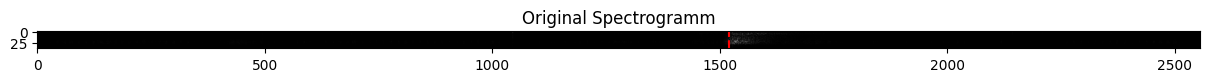

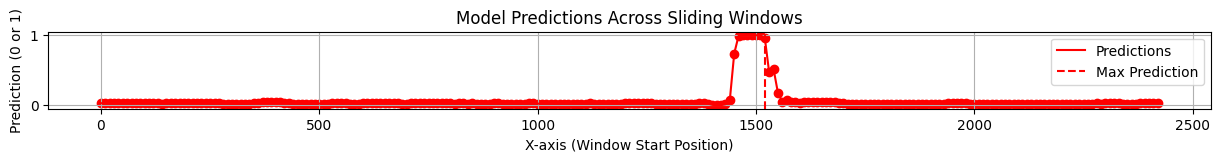

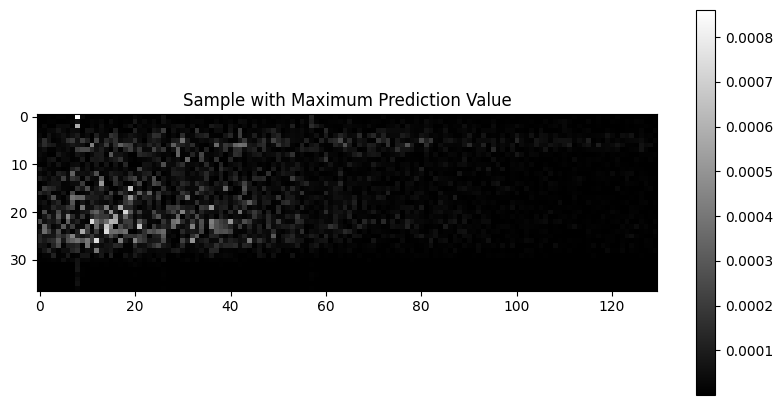

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
740


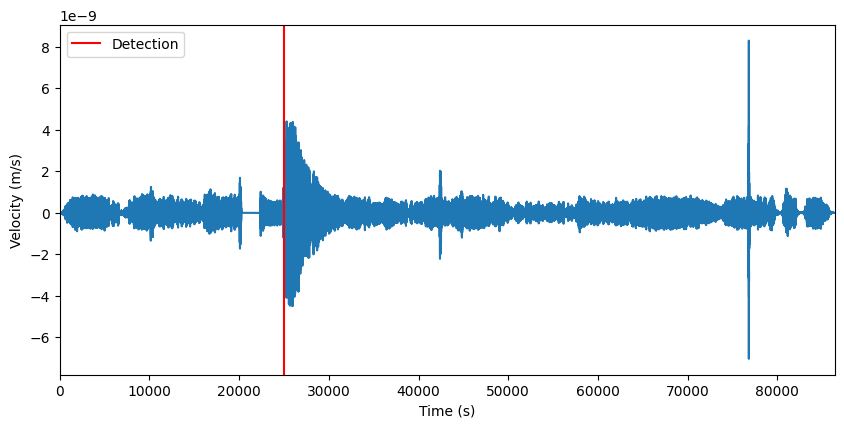

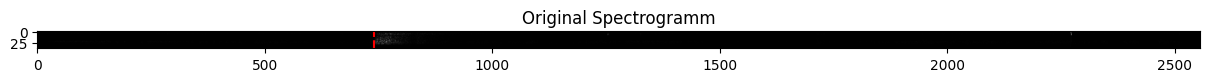

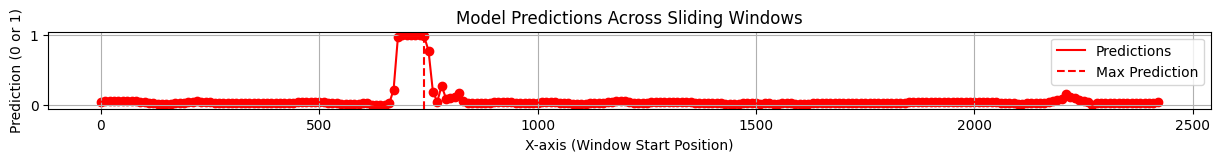

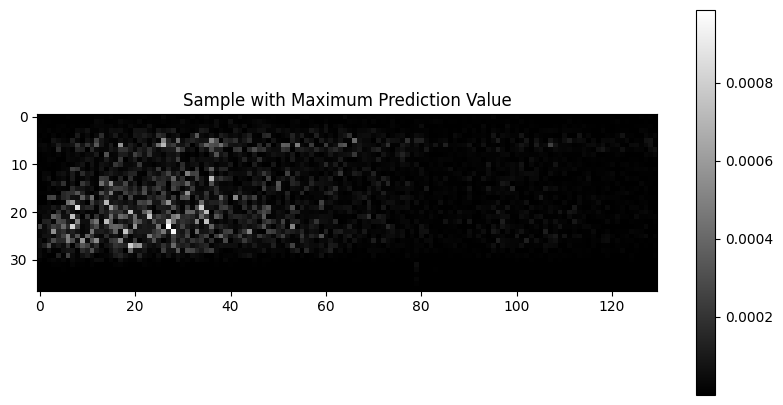

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2210


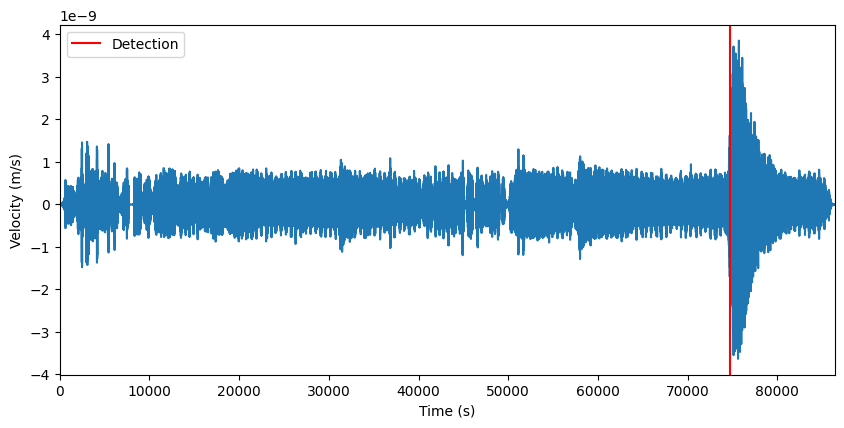

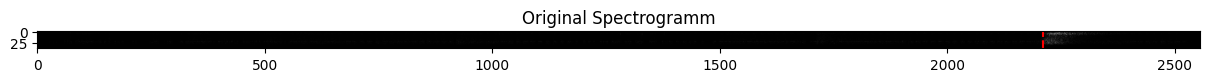

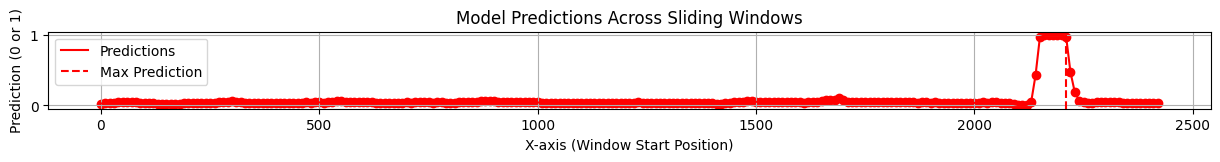

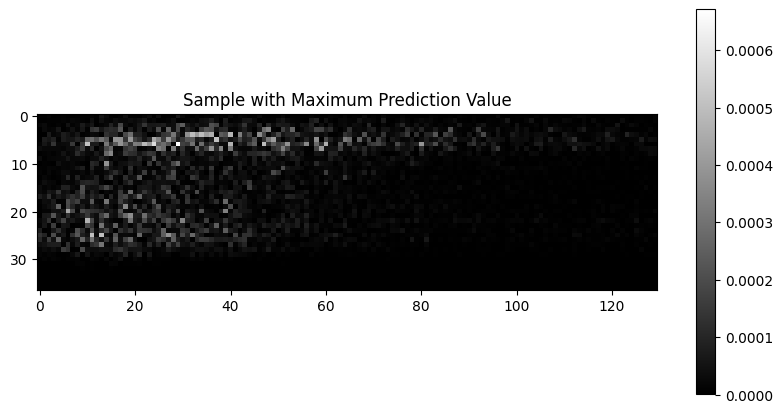

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1470


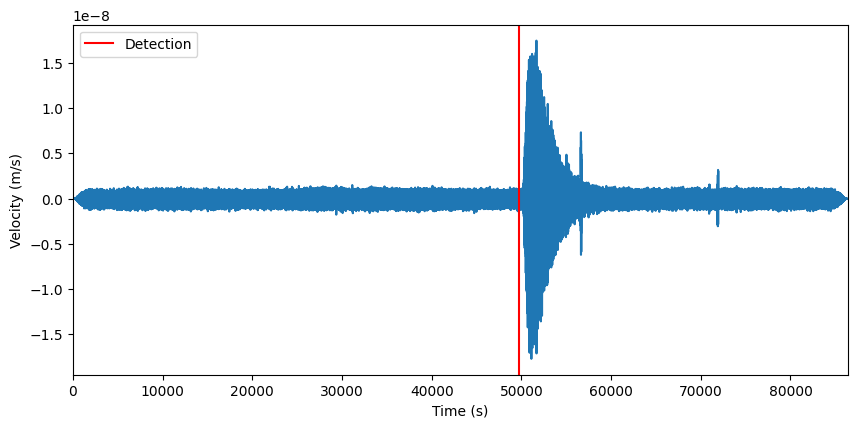

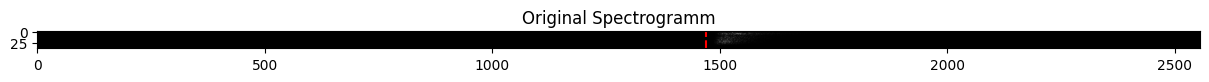

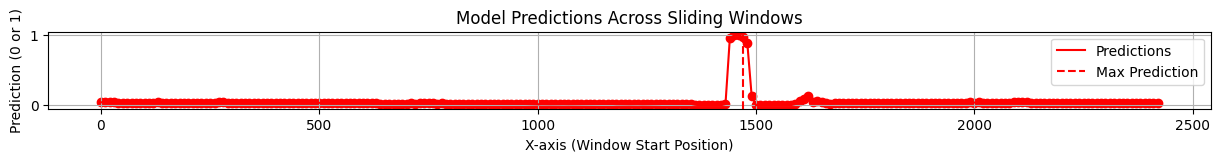

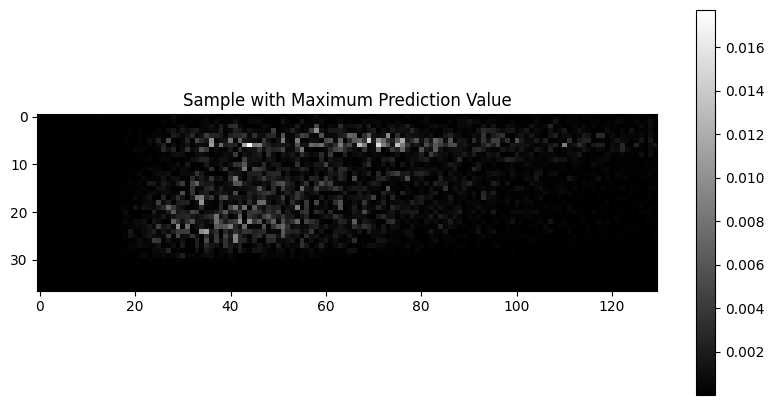

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.62720000e+04, 8.63058113e+04, 8.63396226e+04])]
1850


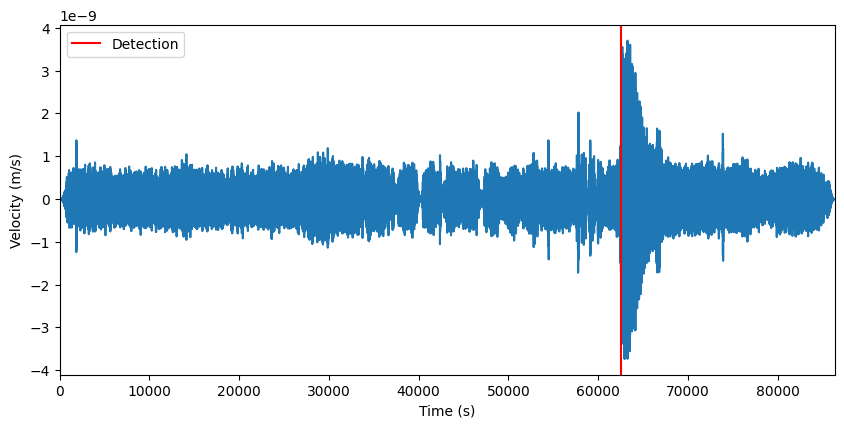

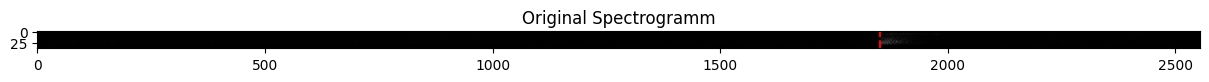

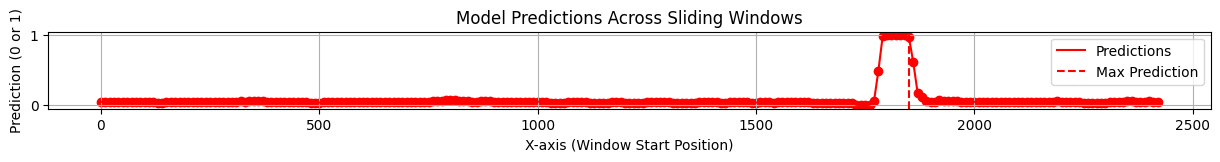

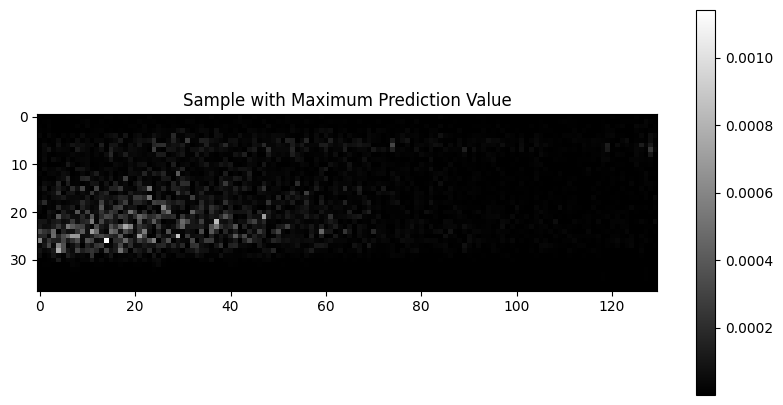

Number of positive samples: 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       7.19360000e+04, 7.19698113e+04, 7.20036226e+04])]
1770


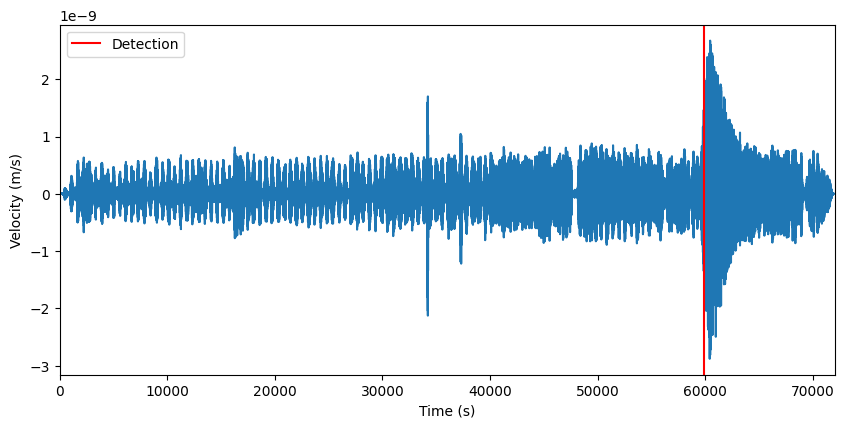

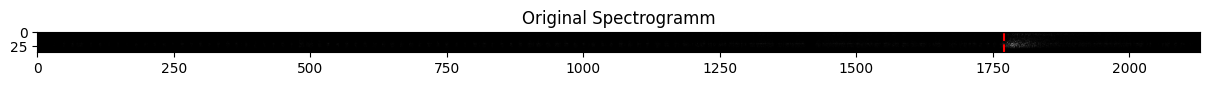

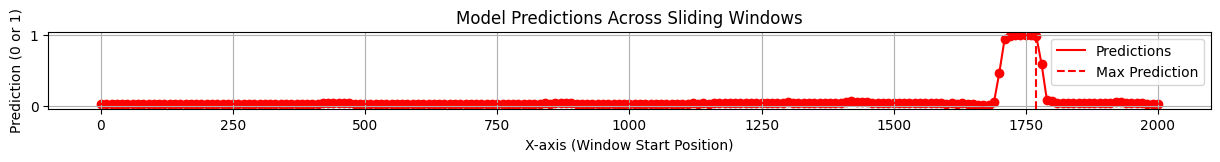

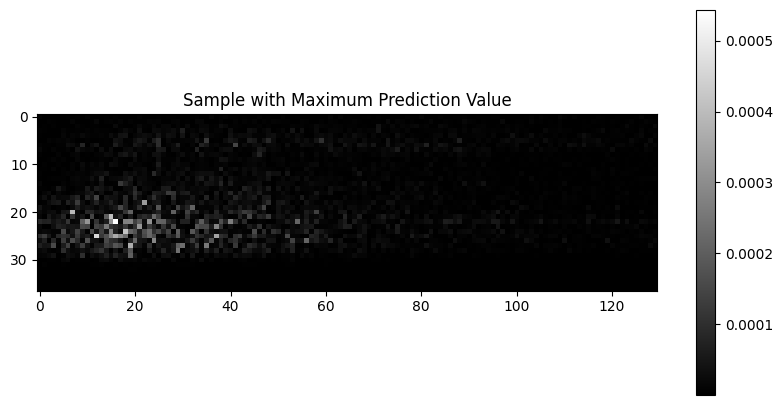

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
320


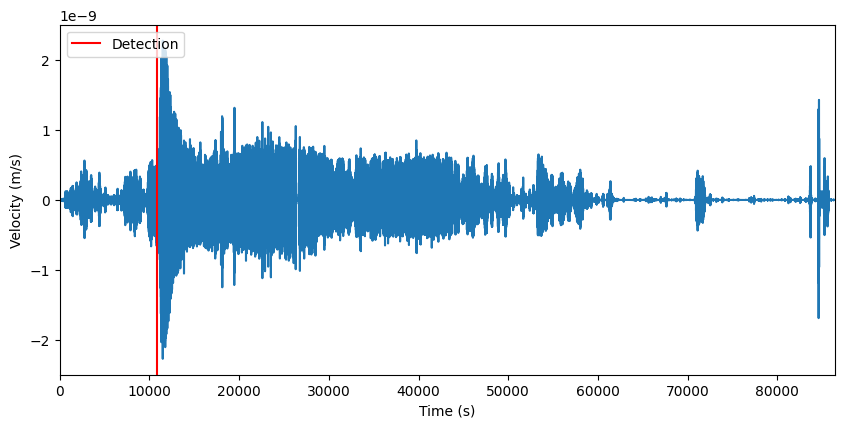

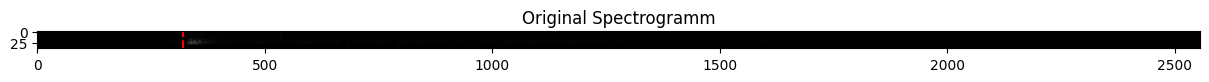

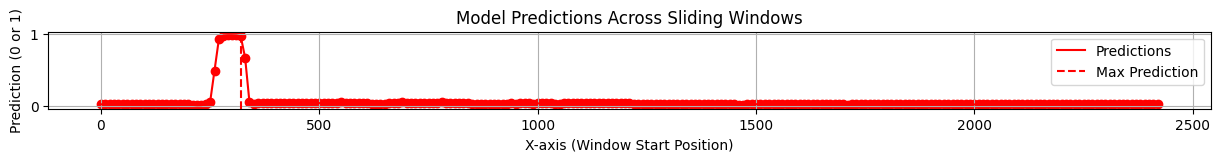

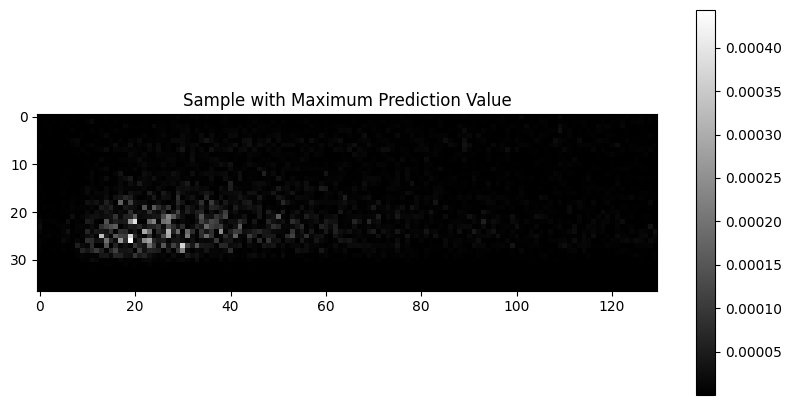

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1480


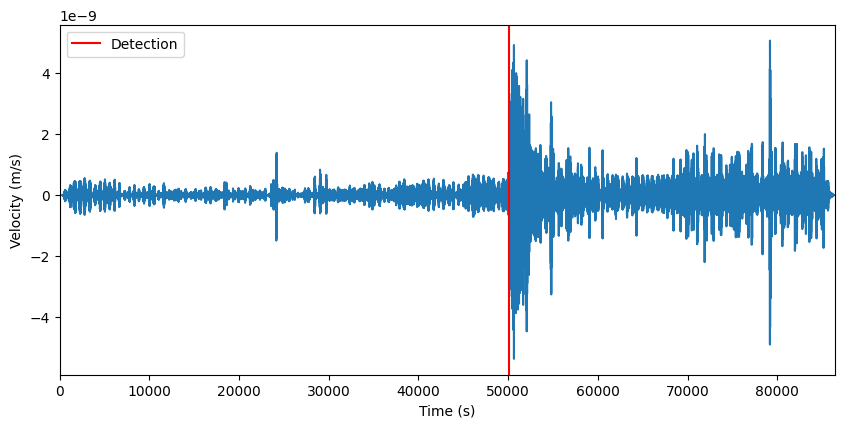

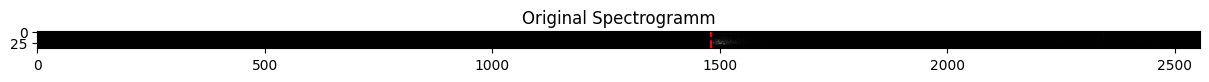

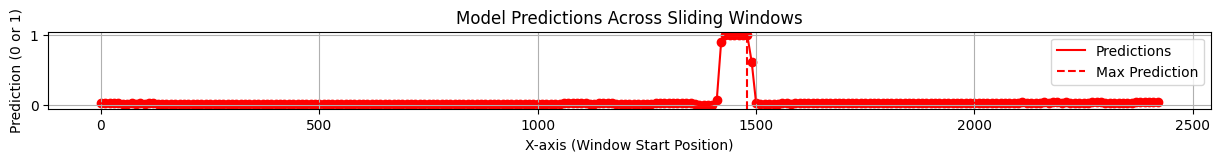

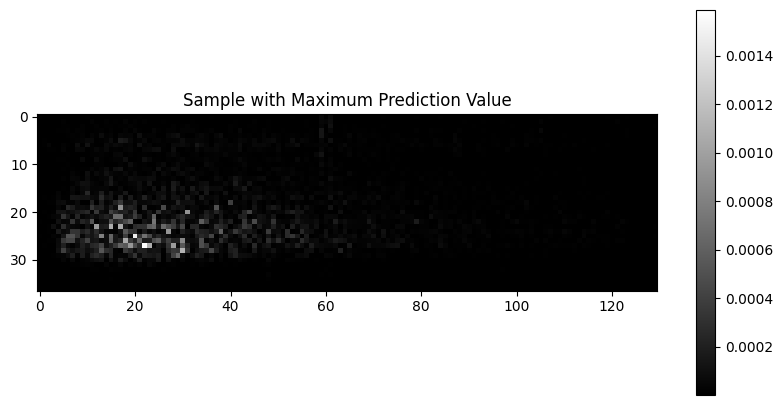

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
810


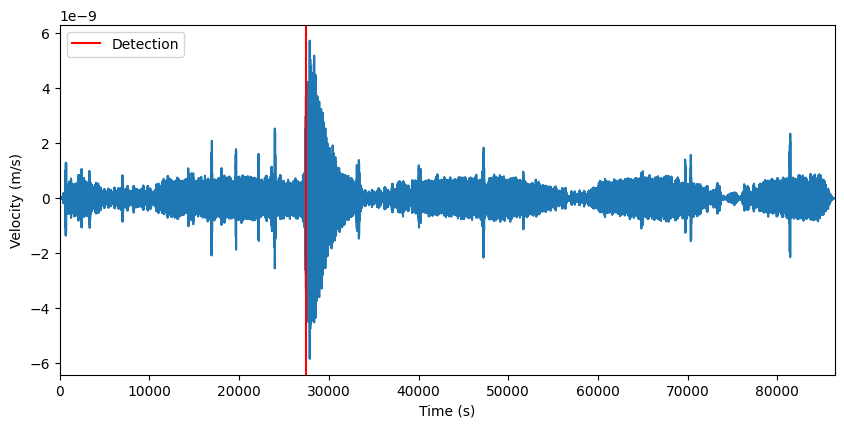

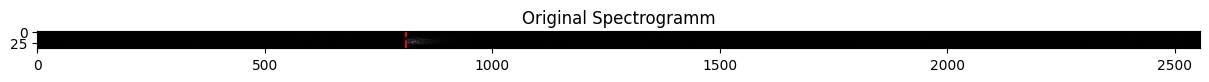

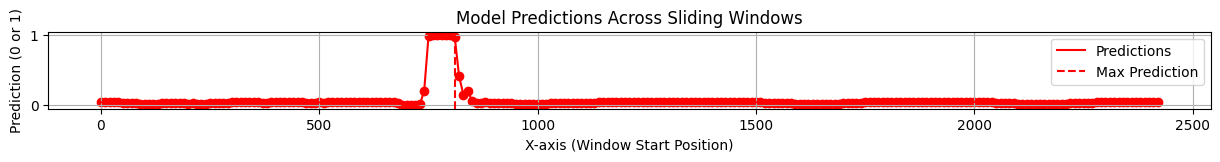

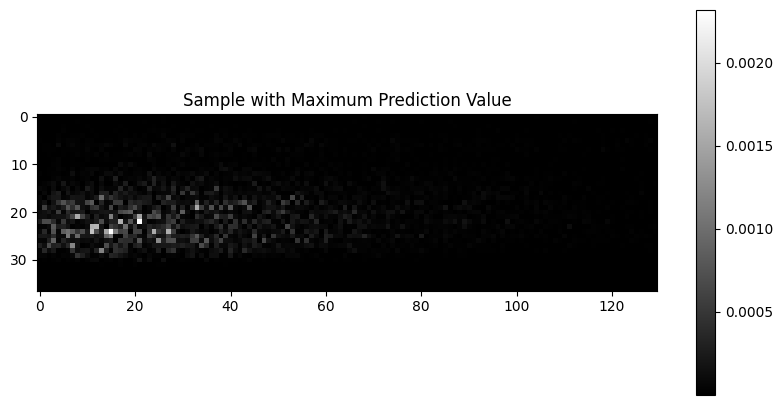

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.57986415e+04, 8.58324528e+04, 8.58662642e+04])]
2100


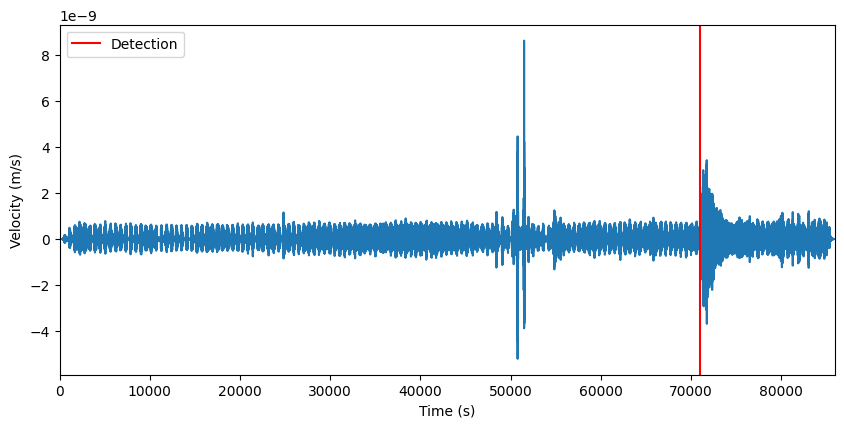

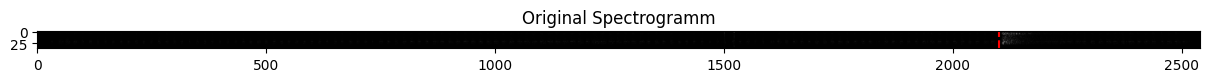

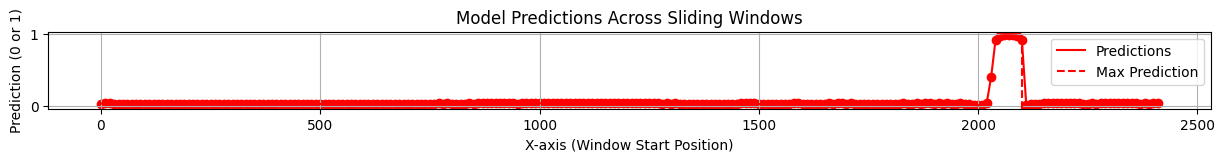

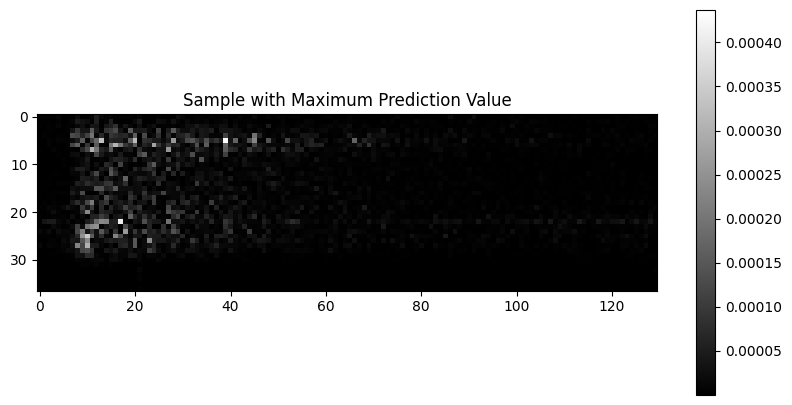

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1440


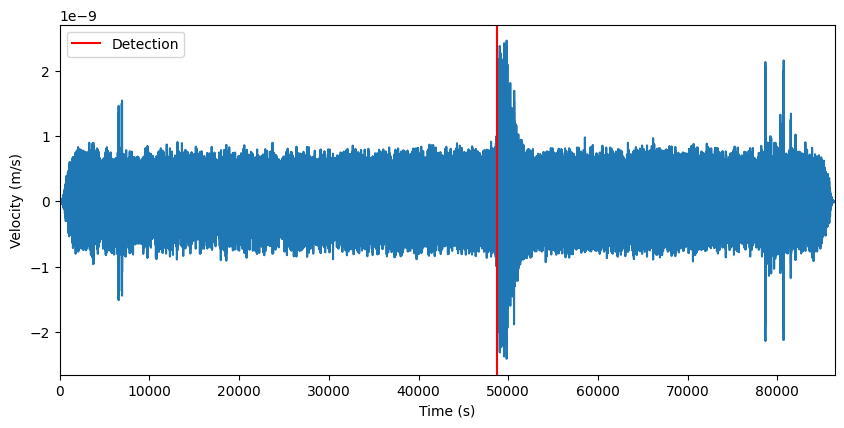

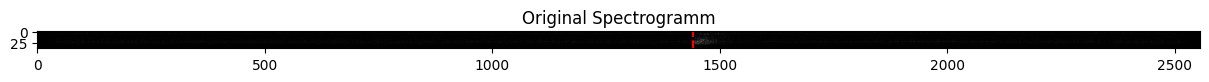

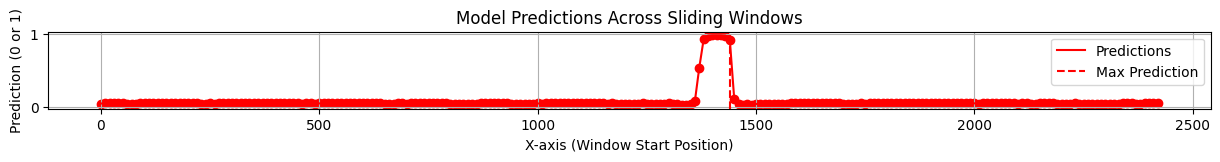

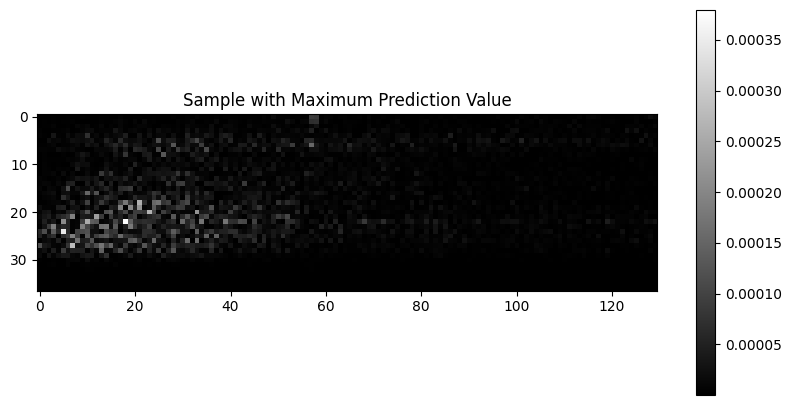

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1880


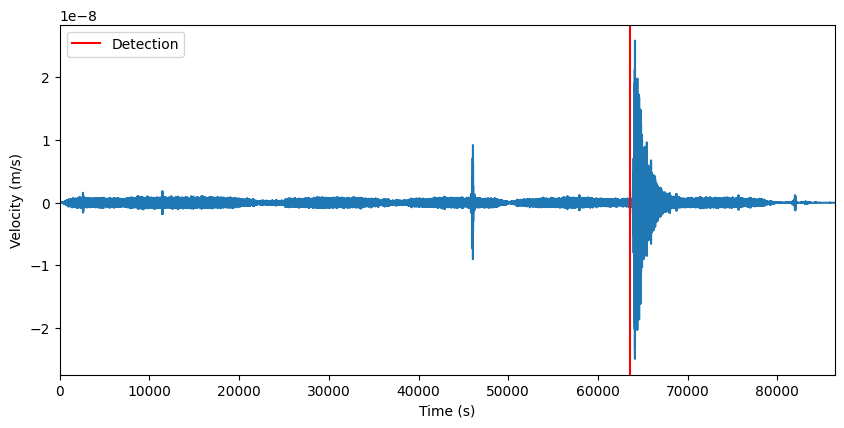

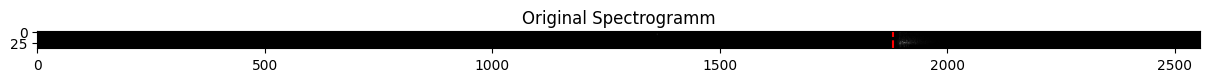

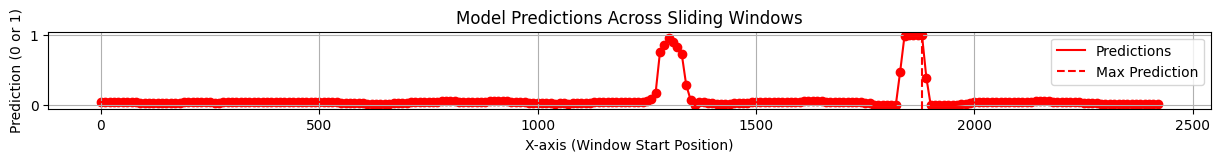

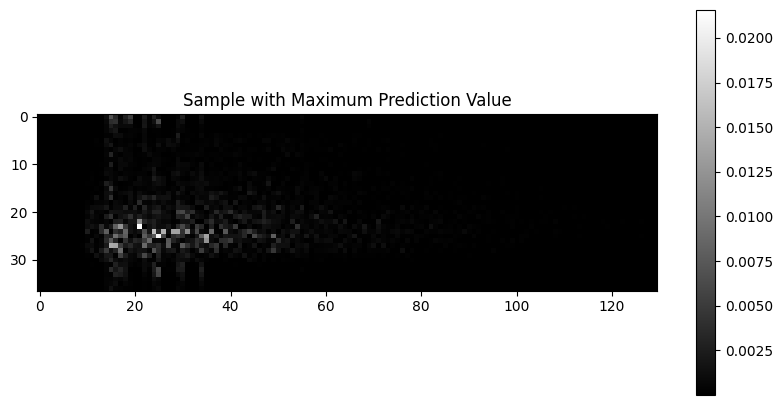

Number of positive samples: 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       6.80476981e+04, 6.80815094e+04, 6.81153208e+04])]
980


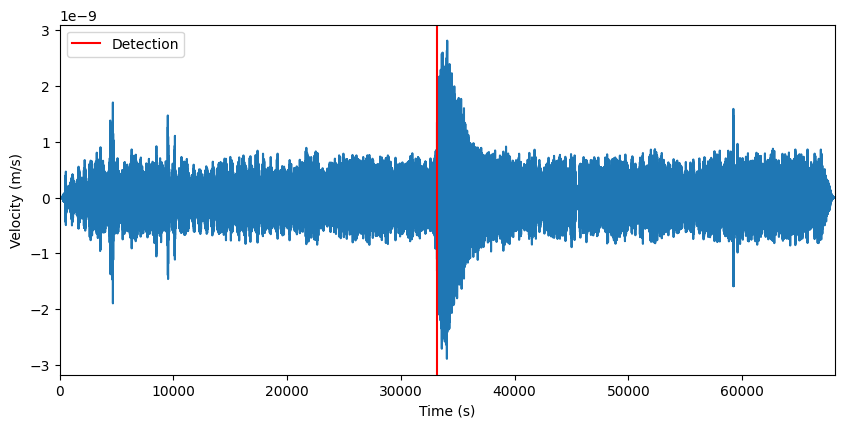

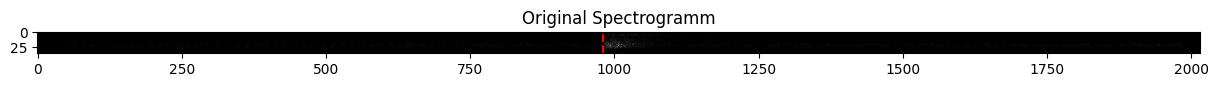

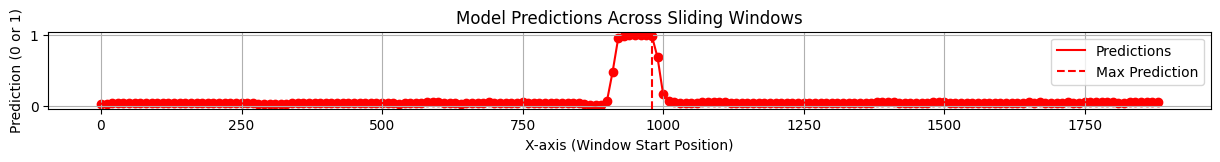

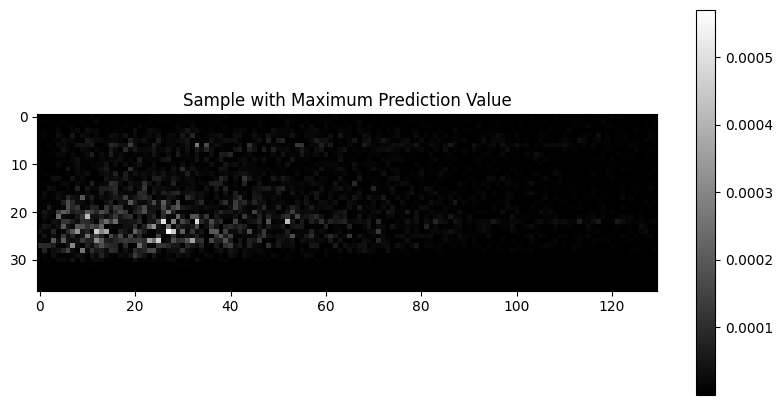

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2200


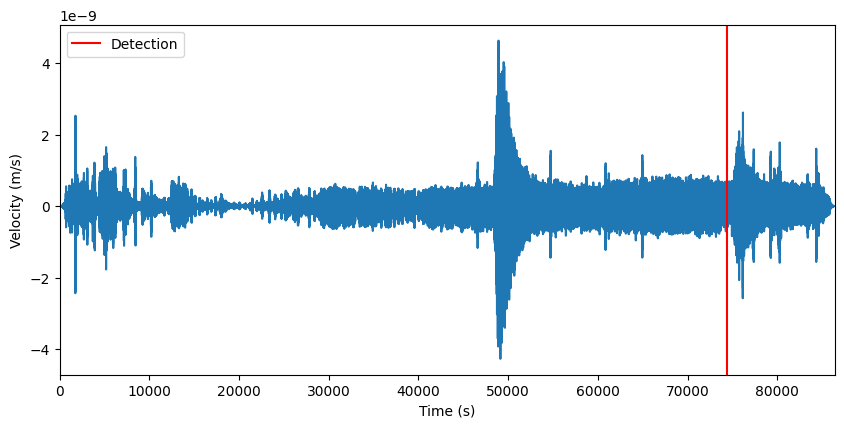

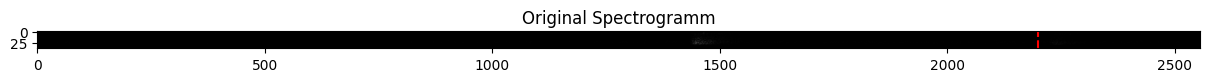

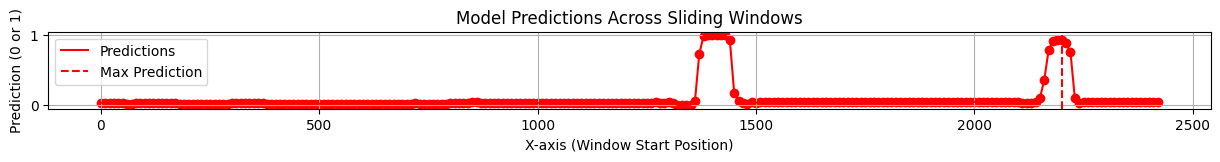

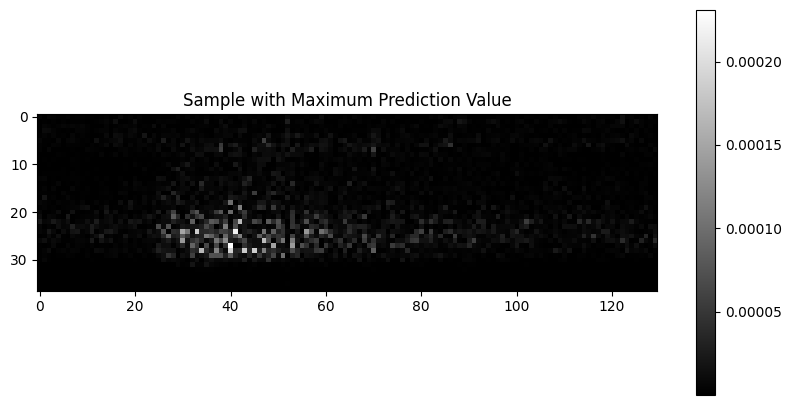

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
220


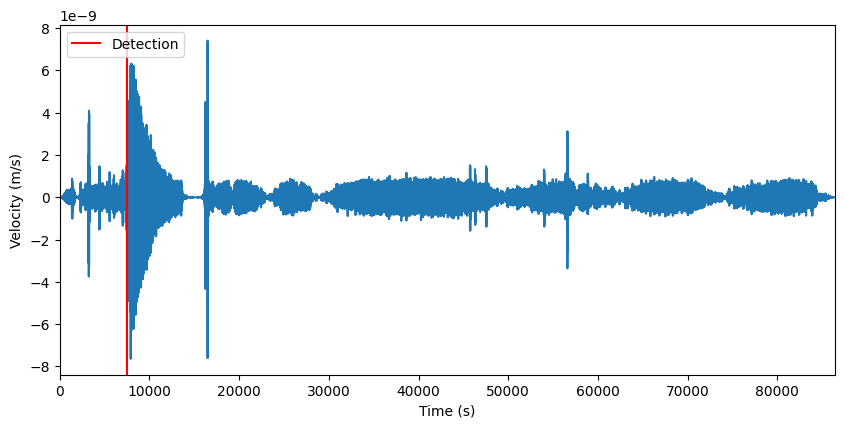

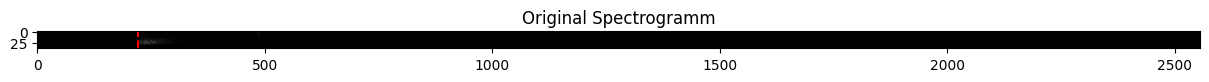

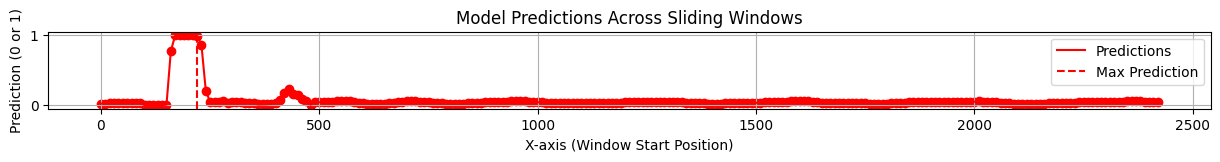

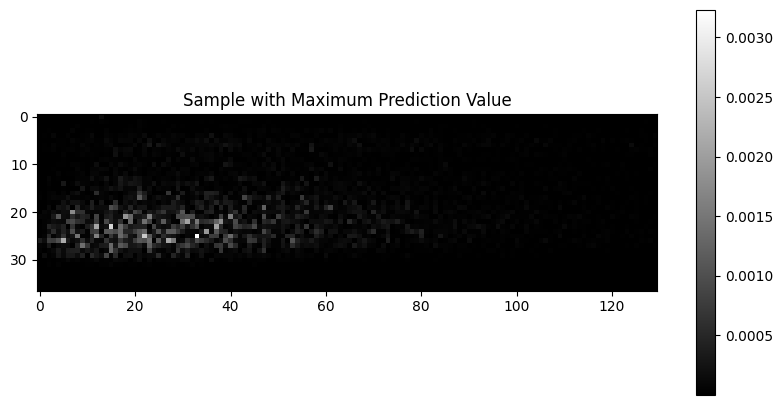

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2370


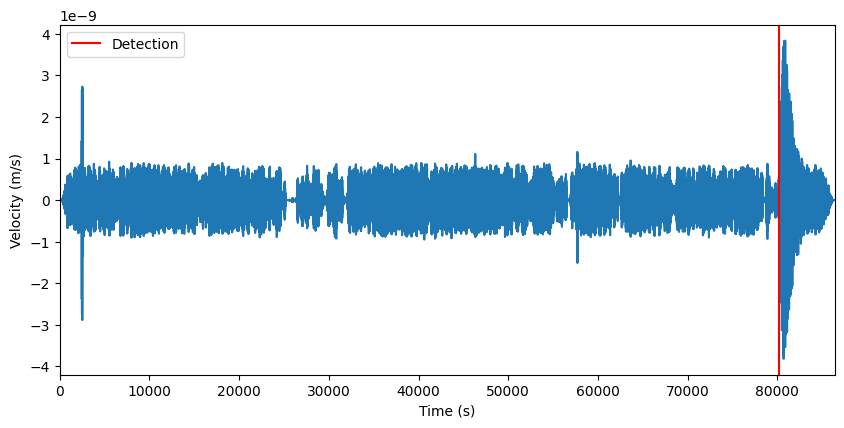

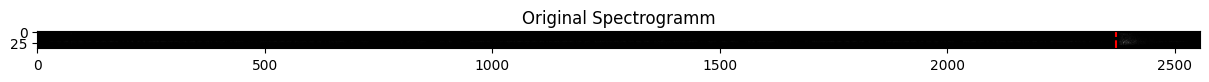

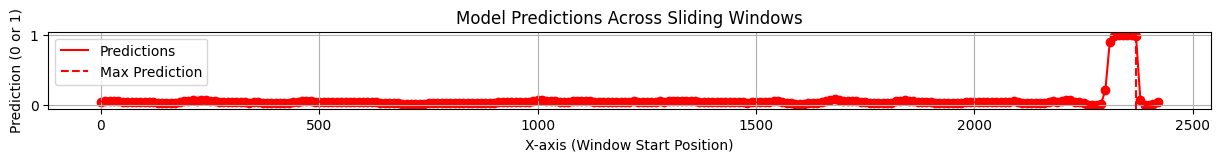

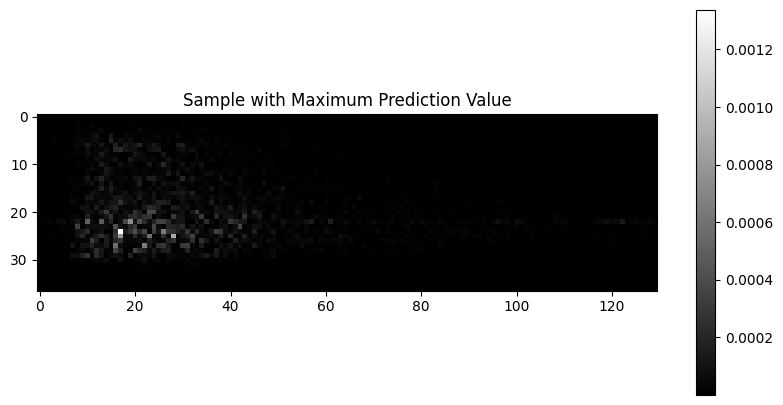

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1860


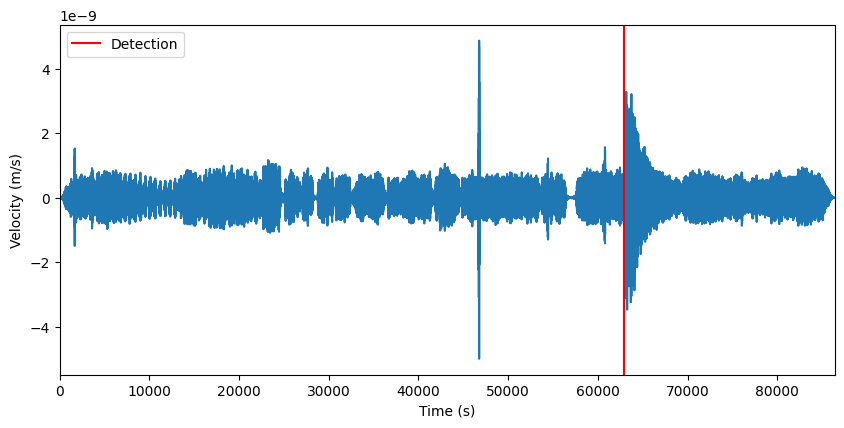

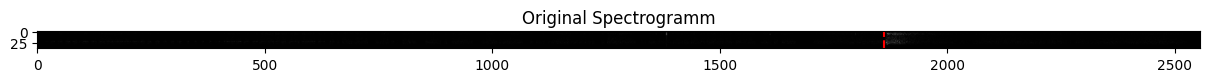

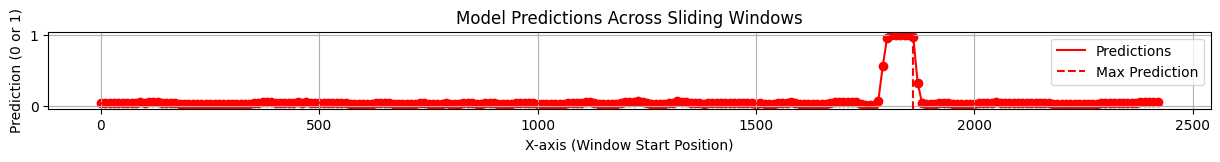

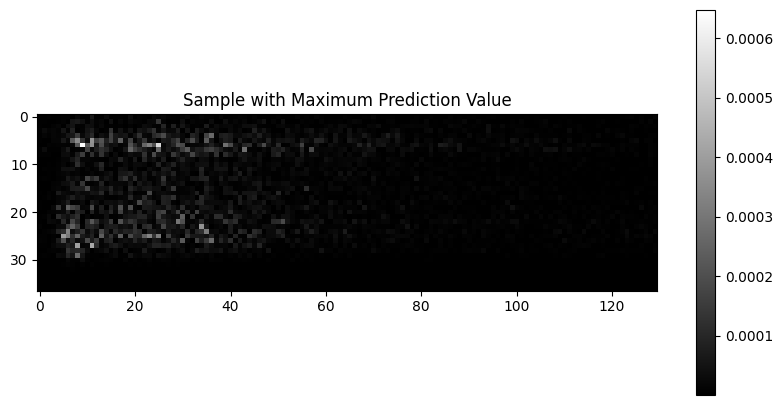

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
420


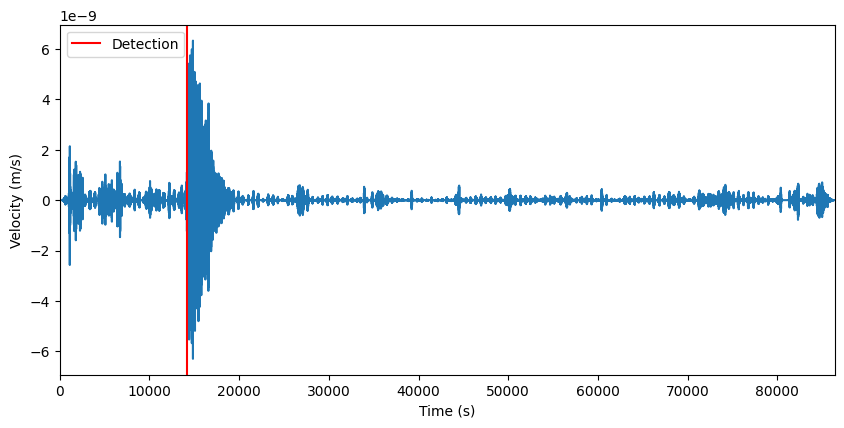

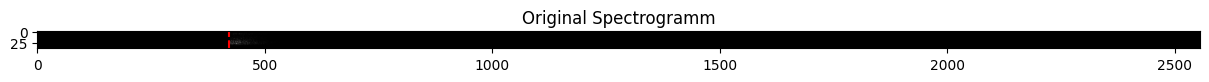

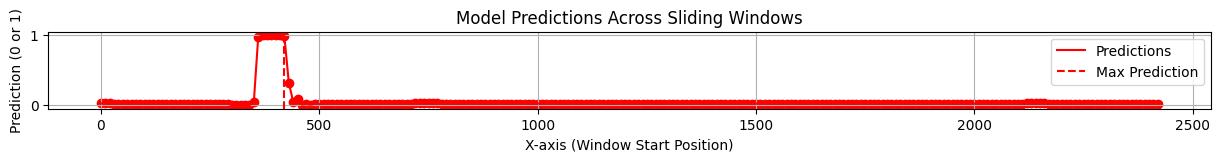

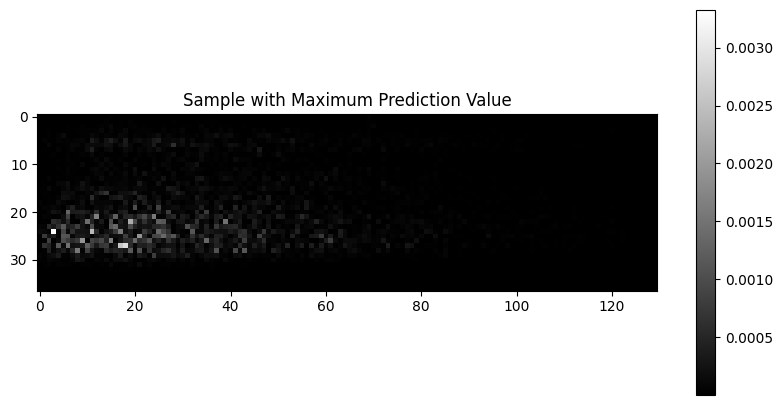

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1860


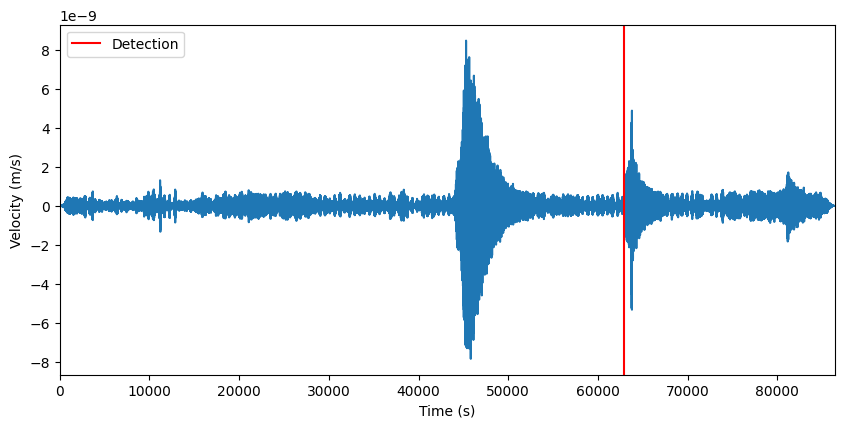

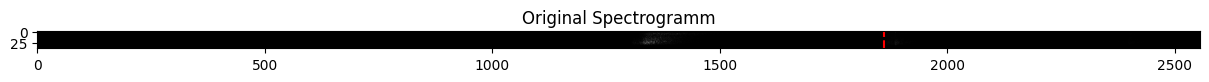

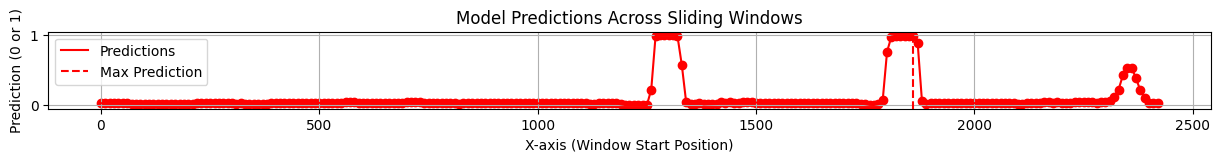

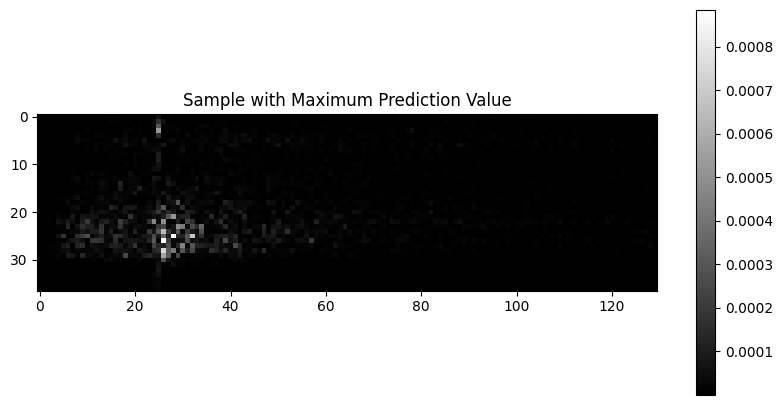

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1430


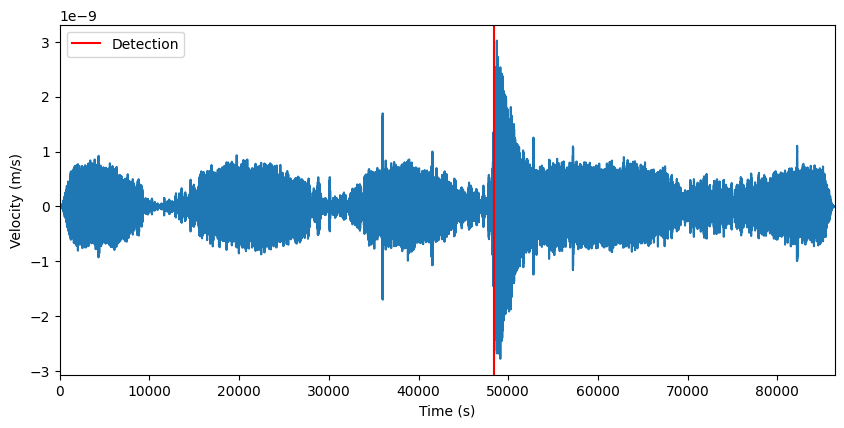

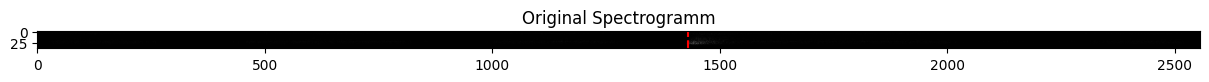

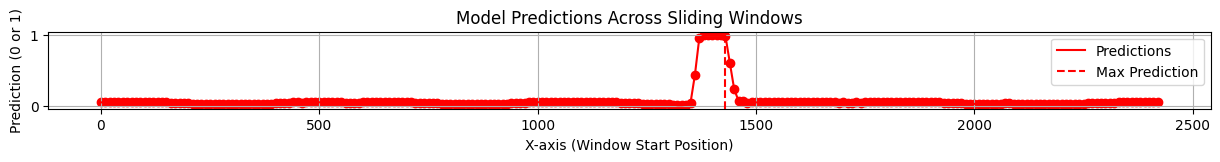

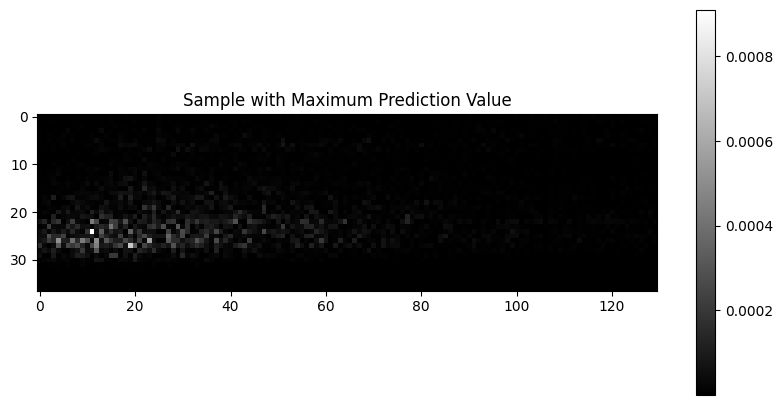

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1720


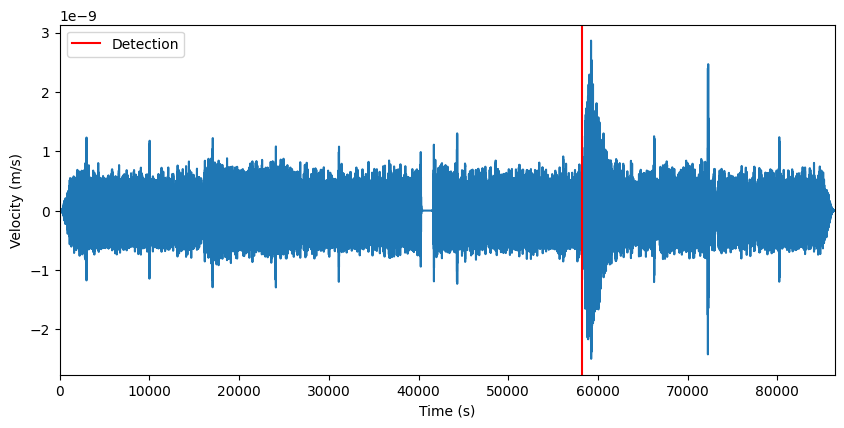

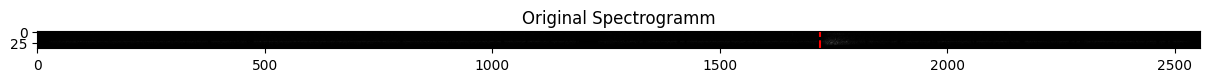

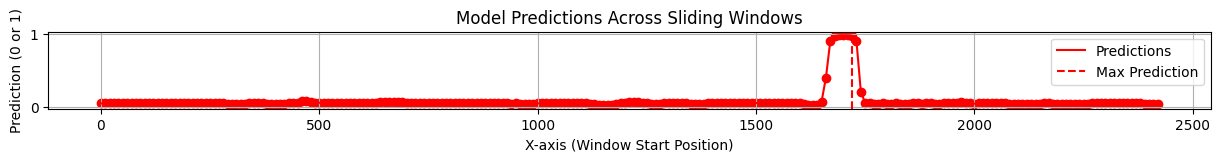

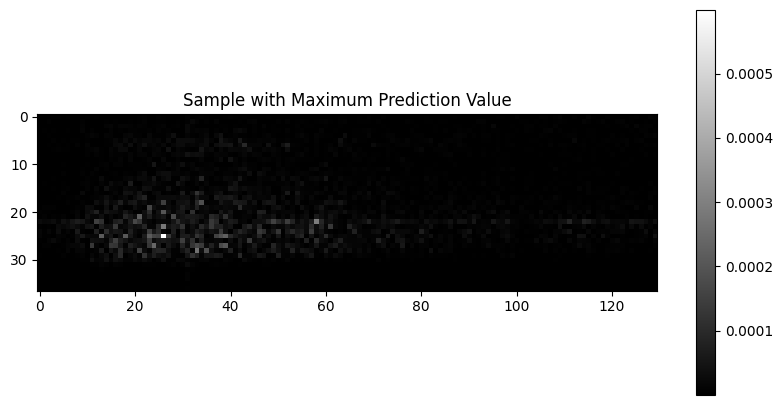

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
1060


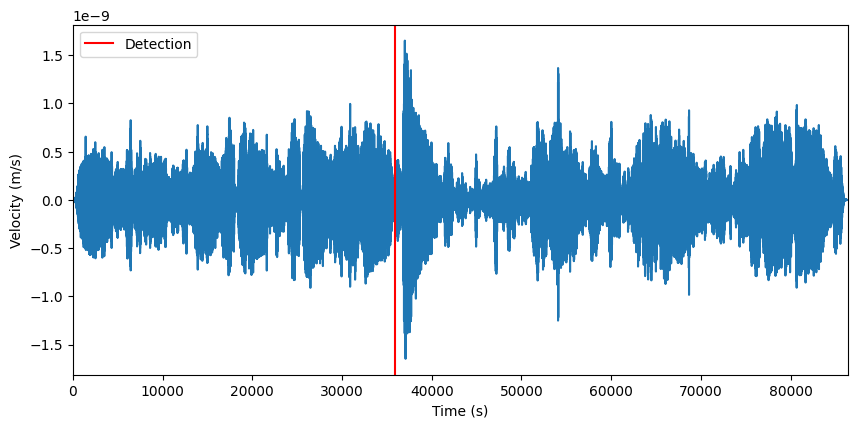

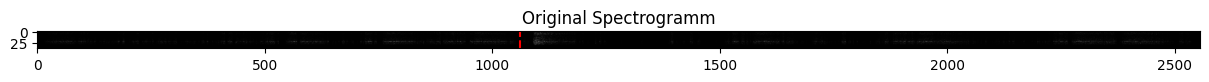

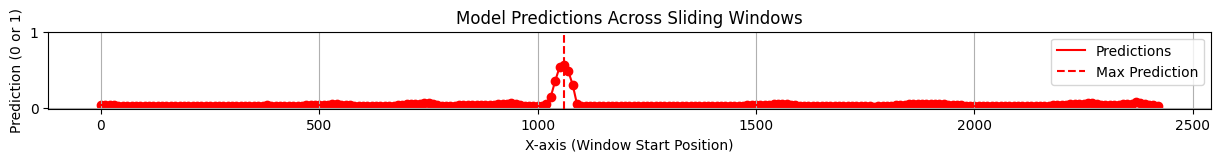

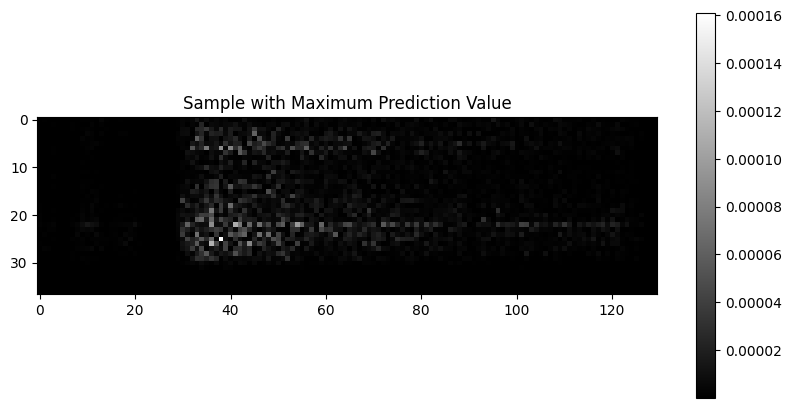

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.50886038e+04, 8.51224151e+04, 8.51562264e+04])]
2200


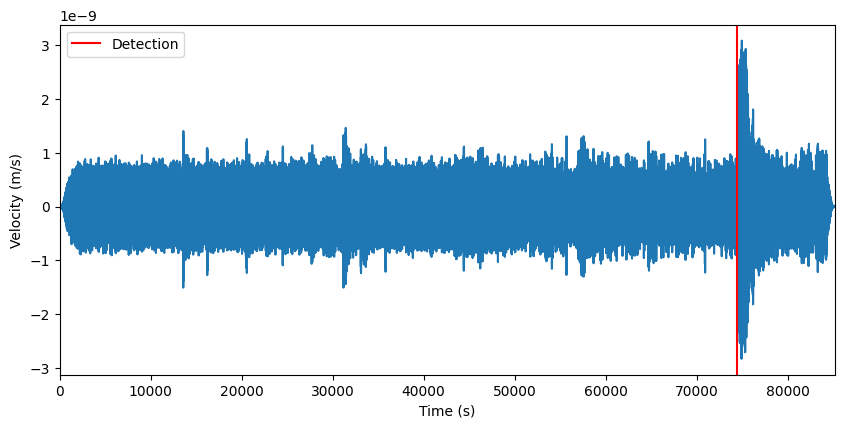

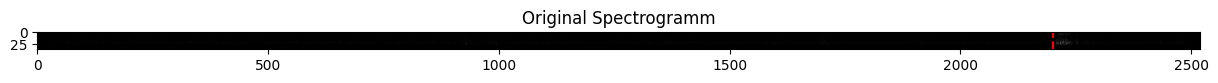

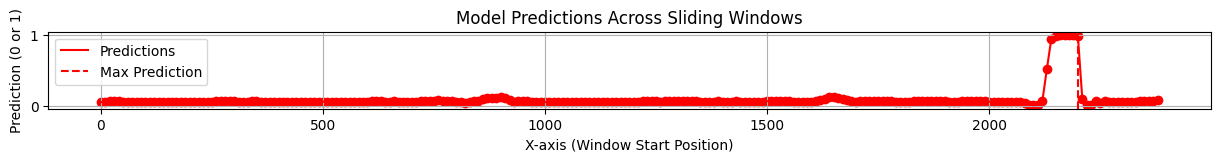

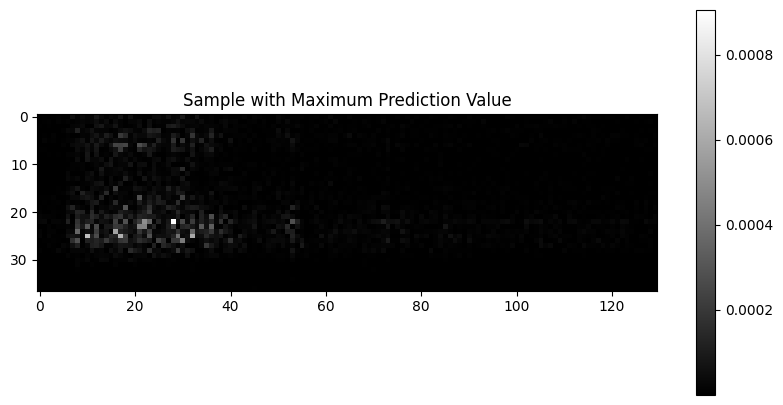

Number of positive samples: 1
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[array([1.93207547e+01, 5.31320755e+01, 8.69433962e+01, ...,
       8.63058113e+04, 8.63396226e+04, 8.63734340e+04])]
2420


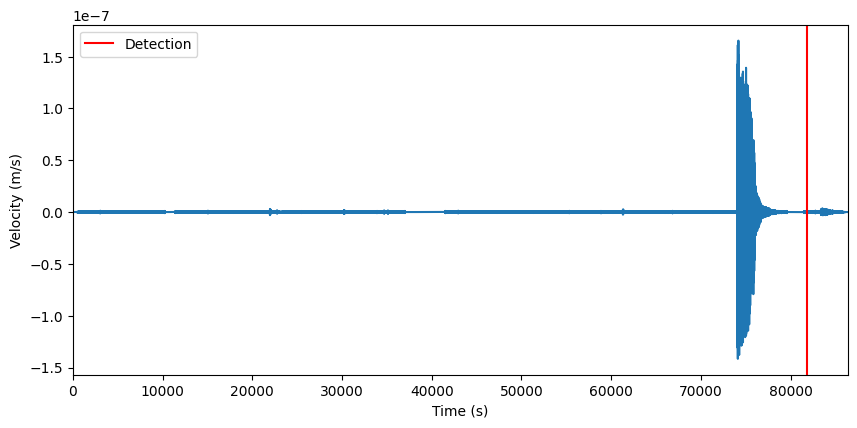

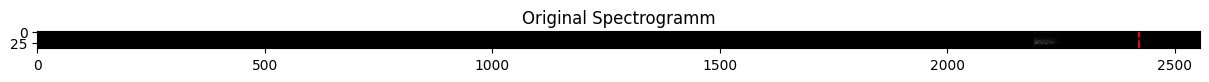

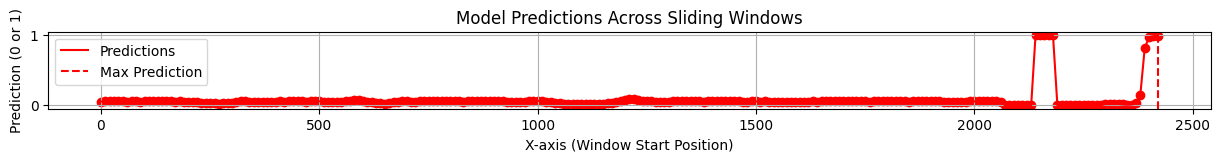

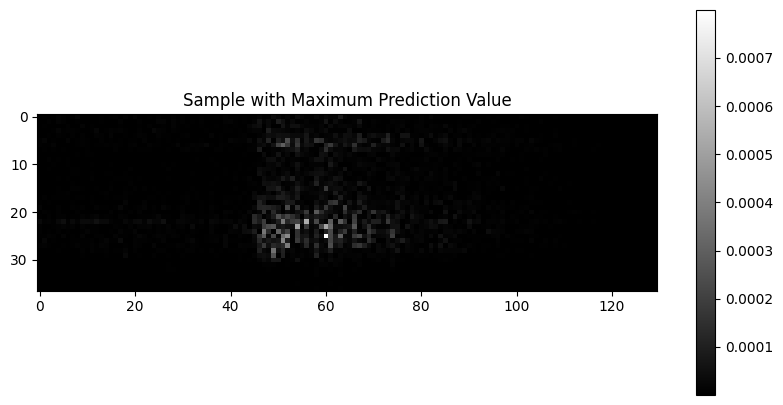

In [10]:
# test script


# Iterate through detection times and compile them
detection_times = []
fnames = []
triggers = []

directory = "./data/lunar/test/"
data_set = "S12_GradeB"
data_directory = f"{directory}data/{data_set}/"
cat_file = f"{directory}catalogs_ML/{data_set}.csv"

mseed_filenames = [
    os.path.splitext(filename)[0]  # Dateiname ohne Erweiterung
    for filename in os.listdir(data_directory)
    if filename.endswith('.mseed')  # Filter für .mseed Dateien
]

for path in mseed_filenames:

    fnames.append(path)

    images = [load_image(data_directory, path)[0]]

    timestamps = [load_image(data_directory, path)[1]]
    t = [load_image(data_directory, path)[2]]
    y_coordinates = np.zeros(len(images))  # Corresponding y-coordinates where the target starts for each image

    window_size = (37, 130)  # (height, width)
    step_size = 10

    # Create dataset
    samples, labels, postitions, positivvvs = create_dataset(images, y_coordinates, window_size, step_size)

    # Normalisiere die Samples (Wertebereich von 0 bis 1) durch den globalen Maximalwert
    samples = samples / global_max

    model = tf.keras.models.load_model('cnn_detector.h5')

    predictions = model.predict(samples)
    # print(predictions)
    max_prediction_value = np.max(predictions)

    max_indices = np.where(predictions > max_prediction_value - 0.08)[0]

    last_max_index = max_indices[-1]

    triggers.append(t[0][postitions[last_max_index]])
    detection_times.append(0)

    mseed_file = f'{data_directory}{path}.mseed'
    st = read(mseed_file)

    # This is how you get the data and the time, which is in seconds
    tr = st.traces[0].copy()
    tr_times = tr.times()
    tr_data = tr.data

    if True:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.subplot(2, 1, 1)
        # Plot trace
        ax.plot(tr_times,tr_data)

        # Mark detection
        print(t)
        print(postitions[last_max_index])
        ax.axvline(x = t[0][postitions[last_max_index]], color='red',label='Detection')
        ax.legend(loc='upper left')

        # Make the plot pretty
        ax.set_xlim([min(tr_times),max(tr_times)])
        ax.set_ylabel('Velocity (m/s)')
        ax.set_xlabel('Time (s)')
        plt.show()


        # Plot the original image and draw red lines at detected regions
        plt.figure(figsize=(15, 50))
        plt.imshow(images[0], cmap='gray')
        plt.title('Original Spectrogramm')

        plt.axvline(x=postitions[last_max_index], color='red', linestyle='--', label='Max Prediction')

        plt.figure(figsize=(15, 1))
        plt.plot(postitions, predictions, 'r-', label='Predictions')
        plt.scatter(postitions, predictions, color='red')  # Scatter plot for better visibility

        plt.axvline(x=postitions[last_max_index], color='red', linestyle='--', label='Max Prediction')

        plt.xlabel('X-axis (Window Start Position)')
        plt.ylabel('Prediction (0 or 1)')
        plt.title('Model Predictions Across Sliding Windows')
        plt.yticks([0, 1])
        plt.grid(True)
        plt.legend()
        plt.show()

        resized_sample = cv2.resize(samples[last_max_index], (window_size[1], window_size[0]))

        plt.figure(figsize=(10, 5))
        plt.imshow(resized_sample, cmap='gray')
        plt.title('Sample with Maximum Prediction Value')
        plt.colorbar()
        plt.show()


# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':triggers})
# detect_df.head()
detect_df.to_csv(cat_file, index=False)